In [6]:
import numpy as np

kmin=0.9
kmax=0.98
pmin=0.4
pmax=0.6
kk=np.linspace(kmin,kmax,10)#行向量
pp=np.linspace(pmin,pmax,10)
kk=kk.reshape((1,10))
pp=pp.reshape((1,10))
#print(k)
ones=np.ones((10,1))
#print(ones)
kk=np.dot(ones,kk)
pp=np.dot(ones,pp)
# print(k)
kk=np.transpose(kk)
kk=kk.reshape((100,1))
pp=pp.reshape((100,1))
# print(k)
Parameter=np.hstack((kk,pp))
Welfare=np.zeros((100,1))
FirmWelfare=np.zeros((100,1))
SocialWelfare=np.zeros((100,1))

# 3.14晚上，下面这一块先运行前10个
# 3.15早上R语言，运行前80个

In [2]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy

for i in range(0,80,1):
    BBBB=200;
    k=Parameter[i,0];
    p=Parameter[i,1];
    for count in range(0,50,1):
        gamma=0.9;
        epsilon=-0.3;

        rho=0.9;
        C=50;

        a=0.8;
        eta=0.6;
        xmean=a/eta;
        sigma=0.8;
        sd=sigma**2/2/eta
        xmin=xmean-2*sd
        xmax=xmean+2*sd

        I=1000;
        hmin=0.0001;
        hmax=100;
        h=np.linspace(hmin,hmax,I);   #列向量  
                                      #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
        h=h.reshape(I,1);
        #print(h);
        dh=(hmax-hmin)/(I-1);

        J=7;
        x=np.linspace(xmin,xmax,J);    # 行向量
        x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
        dx=(xmax-xmin)/(J-1);
        dx2=dx**2;

        hh=np.dot(h,np.ones((1,J)));
        xx=np.dot(np.ones((I,1)),x);

        mu=a-x*eta+BBBB;      
        s2=0.5*sigma**2;

        Vhf = np.zeros((I,J));
        Vhb = np.zeros((I,J));
        Vxf = np.zeros((I,J));
        Vxb = np.zeros((I,J));
        Vxx = np.zeros((I,J));
        n = np.zeros((I,J));

        chi =  - np.minimum(mu,0)/dx + s2/dx2;              
        yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
        zeta = np.maximum(mu,0)/dx + s2/dx2;

        maxit=100;
        crit=10**(-6);
        Delta=1000;

        updiag=np.zeros((I,1));
        for j in range(0,J,1):
            gg=np.tile(zeta[0][j],(I,1));
            updiag=np.vstack([updiag,gg]);

        centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
        for j in range(1,J-1,1):
            gg=np.tile(yy[0][j],(I,1));
            centdiag=np.vstack([centdiag,gg]);
        gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
        centdiag=np.vstack([centdiag,gg])

        lowdiag=np.tile(chi[0][1],(I,1));
        for j in range(2,J,1):
            gg=np.tile(chi[0][j],(I,1));
            lowdiag=np.vstack([lowdiag,gg]);

        centdiag=np.transpose(centdiag);
        Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
        lowdiag=np.transpose(lowdiag);
        Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
        updiag=np.transpose(updiag);
        Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
        Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

        v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
        v=v0;

        maxit=30;
        distm=np.zeros(maxit);
        for m in range(0,maxit,1):   
            V=copy.deepcopy(v);
            Vhf=np.zeros((I,J));
            Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
            Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;

            Vhb=np.zeros((I,J));
            Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
            Vhb[0,:]=(V[1,:]-V[0,:])/dh;

            I_concave=(Vhb>Vhf)+0;

            nf=((1-k)/C*Vhf)**epsilon;
            hf=(1-k)*nf-p*hh;

            nb=((1-k)/C*Vhb)**epsilon;
            hb=(1-k)*nb-p*hh;

            n0=p/(1-k)*hh;
            Vh0=C/(1-k)*n0**(1/epsilon);

            If=(hf>0)+0;
            Ib=(hb<0)+0;

            I0=(1-If-Ib);

            Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

            n=((1-k)/C*Vh_Upwind)**epsilon;
            u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);

            aaa=np.nan_to_num(hf,nan=0)
            hf=aaa
            aaa=np.nan_to_num(hb,nan=0)
            hb=aaa

            X=-np.minimum(hb,0)/dh;
            Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
            Z=np.maximum(hf,0)/dh;

            updiag=0;
            for j in range(0,J,1):
                pp=Z[0:I-1,j];
                pp=pp.reshape(I-1,1)
                gg=np.vstack([pp,0]);
                updiag=np.vstack([updiag,gg]);

            Y=np.transpose(Y);
            centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

            lowdiag=X[1:I,0];
            lowdiag=lowdiag.reshape(I-1,1);
            for j in range(1,J,1):
                pp=X[1:I,j];
                pp=pp.reshape(I-1,1);
                gg=np.vstack([0,pp]);
                lowdiag=np.vstack([lowdiag,gg]);

            centdiag=np.transpose(centdiag);
            AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();

            lowdiag=np.vstack([lowdiag,0]);
            lowdiag=np.transpose(lowdiag);
            AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();

            updiag=np.vstack([updiag,0]);
            updiag=np.transpose(updiag);
            AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();

            AA=AA_centdiag+AA_lowdiag+AA_updiag;

            A=AA+Bswitch;

            if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
                print("Improper Transition Matrix")
                break;

            B=(1/Delta+rho)*identity(I*J).toarray()-A;
            invB=np.linalg.inv(B);

            u=np.transpose(u);
            u_stacked=copy.deepcopy(u.reshape(I*J,1));
            V=np.transpose(V);
            V_stacked=copy.deepcopy(V.reshape(I*J,1));


            b=u_stacked+V_stacked/Delta;

            invBcopy=copy.deepcopy(invB);

            bcopy=np.tile(np.transpose(b),(I*J,1))
            index=np.where(np.isnan(bcopy))
        #     for i in range(0,len(index[0]),1):
        #         if invBcopy[index[0][i],index[1][i]]==0:
        #             bcopy[index[0][i],index[1][i]]=0

        #     index=np.where(np.isinf(bcopy))
        #     for i in range(0,len(index[0]),1):
        #         if invBcopy[index[0][i],index[1][i]]==0:
        #             bcopy[index[0][i],index[1][i]]=0

            V_stacked2=invBcopy*bcopy
            V_stacked2=V_stacked2.sum(axis=1)
            V_stacked2=V_stacked2.reshape(I*J,1)


            V=copy.deepcopy(V_stacked2.reshape(J,I));
            V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

            Vchange=V-v;

            v=copy.deepcopy(V);

            Vchangecopy=copy.deepcopy(Vchange)
            aaa=np.nan_to_num(Vchangecopy,nan=0,posinf=0,neginf=0)  
            Vchangecopy=aaa

            distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
            print(distm[m]);
            print(m);
            if distm[m]<crit:
                print("Value Function Converged, Iteration =",m,distm[m]);
                break;

        AT=np.transpose(A)
        b5=np.zeros((I*J,1))
        i_fix=5
        b5[i_fix-1,0]=0.1
        row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
        AT[i_fix-1,:]=row
        invAT=np.linalg.inv(AT);
        gg=np.dot(invAT,b5);

        g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

        gg=gg/g_sum
        # g=np.transpose(gg).reshape(I,J)
        ggcopy=copy.deepcopy(gg)
        # ggcopy=np.transpose(ggcopy)
        g=ggcopy.reshape(J,I)
        g=np.transpose(g)

        T=k*n+p*hh

        Tg=T*g
        TFW1=np.dot(np.ones((1,I)),Tg)
        TotalFirmWelfare=np.dot(TFW1,np.ones((J,1)))
    #     print('k=',k,'p=',p,'FirmWelfare=',TotalFirmWelfare)
    #     FirmWelfare[i,0]=TotalFirmWelfare

        Vg=V*g
        TSW1=np.dot(np.ones((1,I)),Vg)
        TotalSocialWelfare=np.dot(TSW1,np.ones((J,1)))

        # D=TotalSocialWelfare-TotalFirmWelfare

        # print('次数=',i,'k=',k,'p=',p,'TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'作差=',D)
        print('TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'BBBB',BBBB)
        if abs(BBBB-TotalFirmWelfare)<0.5:
            print('求B的次数',count+1,'第几组k和p',i+1,'最后迭代出的B值',BBBB)
            break
        elif BBBB>TotalFirmWelfare:
            BBBB=TotalFirmWelfare+0.5
        elif BBBB<TotalFirmWelfare:
            BBBB=TotalFirmWelfare-0.5

#         Welfare[i,0]=D
        SocialWelfare[i,0]=TotalSocialWelfare
        FirmWelfare[i,0]=TotalFirmWelfare

35.68072745388725
0
0.902545426254072
1
0.026315826575970647
2
3.1387206956168257e-05
3
1.7760161341584535e-08
4
Value Function Converged, Iteration = 4 1.7760161341584535e-08
TSW= [[789.68626229]] TFW= [[167.7883831]] BBBB 200
35.63659433241302
0
0.9024761446320468
1
0.026316396749358262
2
3.1394362046910373e-05
3
1.7491164072680476e-08
4
Value Function Converged, Iteration = 4 1.7491164072680476e-08
TSW= [[789.59216392]] TFW= [[167.80173267]] BBBB [[168.2883831]]
求B的次数 2 第几组k和p 1 最后迭代出的B值 [[168.2883831]]
35.58808030389434
0
0.9067085303492348
1
0.02651525787169362
2
3.181265156015911e-05
3
1.013325601206816e-08
4
Value Function Converged, Iteration = 4 1.013325601206816e-08
TSW= [[784.84036674]] TFW= [[165.76689181]] BBBB 200
35.5405810690073
0
0.9066334353398702
1
0.026515872199382784
2
3.18204841072145e-05
3
1.0133827998970446e-08
4
Value Function Converged, Iteration = 4 1.0133827998970446e-08
TSW= [[784.73966714]] TFW= [[165.78122047]] BBBB [[166.26689181]]
求B的次数 2 第几组k和p 2 最后迭代出

0.8571654829759048
1
0.021176726128974366
2
2.0985531531181323e-05
3
7.181157002378313e-09
4
Value Function Converged, Iteration = 4 7.181157002378313e-09
TSW= [[757.4236058]] TFW= [[157.54980098]] BBBB 200
35.060842363956
0
0.8570750582142068
1
0.021177400303511007
2
2.0991394951153097e-05
3
7.182102024216874e-09
4
Value Function Converged, Iteration = 4 7.182102024216874e-09
TSW= [[757.29349249]] TFW= [[157.55821135]] BBBB [[158.04980098]]
求B的次数 2 第几组k和p 17 最后迭代出的B值 [[158.04980098]]
35.03327476130389
0
0.8610936364386319
1
0.02133751460927158
2
2.116161773813019e-05
3
1.6515853218379561e-07
4
Value Function Converged, Iteration = 4 1.6515853218379561e-07
TSW= [[754.44489323]] TFW= [[157.63732588]] BBBB 200
34.97142689731389
0
0.861002934736451
1
0.02133819763452749
2
2.1167679921774152e-05
3
1.6477768483014188e-07
4
Value Function Converged, Iteration = 4 1.6477768483014188e-07
TSW= [[754.31819033]] TFW= [[157.65512756]] BBBB [[158.13732588]]
求B的次数 2 第几组k和p 18 最后迭代出的B值 [[158.13732588

0.6886028881979662
1
0.01108724187881549
2
7.452817143871471e-06
3
2.9268001355831075e-09
4
Value Function Converged, Iteration = 4 2.9268001355831075e-09
TSW= [[757.05051105]] TFW= [[164.95197962]] BBBB 200
35.418014419318474
0
0.6885514097038765
1
0.011087620212737903
2
7.453820529690347e-06
3
2.9270275092585507e-09
4
Value Function Converged, Iteration = 4 2.9270275092585507e-09
TSW= [[756.94819924]] TFW= [[164.95890595]] BBBB [[165.45197962]]
求B的次数 2 第几组k和p 33 最后迭代出的B值 [[165.45197962]]
35.374795857772
0
0.6922658234975358
1
0.01117637410411021
2
7.52156328331921e-06
3
8.832961029270336e-08
4
Value Function Converged, Iteration = 4 8.832961029270336e-08
TSW= [[753.65245068]] TFW= [[165.70965248]] BBBB 200
35.32722568115903
0
0.6922152957456653
1
0.011176741278198676
2
7.522787207392412e-06
3
8.755426961215562e-08
4
Value Function Converged, Iteration = 4 8.755426961215562e-08
TSW= [[753.55521302]] TFW= [[165.72371173]] BBBB [[166.20965248]]
求B的次数 2 第几组k和p 34 最后迭代出的B值 [[166.20965248]

0.6267279830597374
1
0.00797127876917969
2
4.831447679265466e-06
3
2.0913155651669513e-09
4
Value Function Converged, Iteration = 4 2.0913155651669513e-09
TSW= [[726.68414519]] TFW= [[159.18490266]] BBBB 200
34.85154378627325
0
0.6266736146482188
1
0.007971645075731004
2
4.8320011316604905e-06
3
2.0914185938636365e-09
4
Value Function Converged, Iteration = 4 2.0914185938636365e-09
TSW= [[726.56530413]] TFW= [[159.19298521]] BBBB [[159.68490266]]
求B的次数 2 第几组k和p 49 最后迭代出的B值 [[159.68490266]]
34.821340873278146
0
0.6305527391010948
1
0.0080777871140576
2
8.226856397897109e-06
3
2.3622855138683008e-07
4
Value Function Converged, Iteration = 4 2.3622855138683008e-07
TSW= [[722.9644961]] TFW= [[155.21814465]] BBBB 200
34.75494704646555
0
0.6304909028904859
1
0.008078027368831897
2
8.13897936069452e-06
3
2.335995610280861e-07
4
Value Function Converged, Iteration = 4 2.335995610280861e-07
TSW= [[722.83433017]] TFW= [[155.23693272]] BBBB [[155.71814465]]
求B的次数 2 第几组k和p 50 最后迭代出的B值 [[155.718144

35.249098195173396
0
0.4345992477853038
1
0.002995095991700225
2
1.6923694801107558e-06
3
9.305161086103908e-10
4
Value Function Converged, Iteration = 4 9.305161086103908e-10
TSW= [[717.00524069]] TFW= [[164.51289785]] BBBB 200
35.1995016752699
0
0.43457376370163203
1
0.0029952519597635785
2
1.6924504748772051e-06
3
9.305551884608576e-10
4
Value Function Converged, Iteration = 4 9.305551884608576e-10
TSW= [[716.90686781]] TFW= [[164.51991221]] BBBB [[165.01289785]]
求B的次数 2 第几组k和p 65 最后迭代出的B值 [[165.01289785]]
35.1574057506101
0
0.4372272392536871
1
0.0030187344703840324
2
1.6873978552212066e-06
3
8.868141776474658e-10
4
Value Function Converged, Iteration = 4 8.868141776474658e-10
TSW= [[714.09305825]] TFW= [[165.29817732]] BBBB 200
35.1091639178016
0
0.4372022023218989
1
0.003018890031956545
2
1.6874920909515367e-06
3
8.86863915638969e-10
4
Value Function Converged, Iteration = 4 8.86863915638969e-10
TSW= [[713.99763182]] TFW= [[165.30503424]] BBBB [[165.79817732]]
求B的次数 2 第几组k和p 66 最

In [3]:
print(FirmWelfare)
print("--------------------------------")
print(SocialWelfare)
print("--------------------------------")
# print(Welfare)

[[167.7883831 ]
 [165.76689181]
 [164.71635902]
 [162.66898961]
 [159.81552762]
 [159.11232217]
 [157.41369683]
 [155.67304992]
 [154.62077331]
 [154.20658241]
 [168.24795554]
 [165.62501142]
 [164.481072  ]
 [163.54832461]
 [160.34935092]
 [160.22014465]
 [157.54980098]
 [157.63732588]
 [154.28721515]
 [154.97961528]
 [169.93867632]
 [166.99877843]
 [164.16085334]
 [164.56609945]
 [160.94911371]
 [161.44936431]
 [157.66162584]
 [158.39099113]
 [154.5055569 ]
 [154.50332533]
 [171.02750256]
 [168.6317185 ]
 [164.95197962]
 [165.70965248]
 [161.63240195]
 [162.40393178]
 [157.73241359]
 [158.46210635]
 [157.15653101]
 [153.8196192 ]
 [169.75104714]
 [170.49427724]
 [166.38946167]
 [165.96609867]
 [162.42460611]
 [163.19991741]
 [158.39875977]
 [158.46296312]
 [159.18490266]
 [155.21814465]
 [172.21991115]
 [169.16581232]
 [168.17127864]
 [166.02676339]
 [163.36416021]
 [164.14395634]
 [160.13720604]
 [158.34054048]
 [159.06192227]
 [159.4908041 ]
 [175.42366809]
 [169.61493226]
 [170.46

# 3.15下午，运行后20个

In [7]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy

for i in range(80,100,1):
    BBBB=200;
    k=Parameter[i,0];
    p=Parameter[i,1];
    for count in range(0,50,1):
        gamma=0.9;
        epsilon=-0.3;

        rho=0.9;
        C=50;

        a=0.8;
        eta=0.6;
        xmean=a/eta;
        sigma=0.8;
        sd=sigma**2/2/eta
        xmin=xmean-2*sd
        xmax=xmean+2*sd

        I=1000;
        hmin=0.0001;
        hmax=100;
        h=np.linspace(hmin,hmax,I);   #列向量  
                                      #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
        h=h.reshape(I,1);
        #print(h);
        dh=(hmax-hmin)/(I-1);

        J=7;
        x=np.linspace(xmin,xmax,J);    # 行向量
        x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
        dx=(xmax-xmin)/(J-1);
        dx2=dx**2;

        hh=np.dot(h,np.ones((1,J)));
        xx=np.dot(np.ones((I,1)),x);

        mu=a-x*eta+BBBB;      
        s2=0.5*sigma**2;

        Vhf = np.zeros((I,J));
        Vhb = np.zeros((I,J));
        Vxf = np.zeros((I,J));
        Vxb = np.zeros((I,J));
        Vxx = np.zeros((I,J));
        n = np.zeros((I,J));

        chi =  - np.minimum(mu,0)/dx + s2/dx2;              
        yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
        zeta = np.maximum(mu,0)/dx + s2/dx2;

        maxit=100;
        crit=10**(-6);
        Delta=1000;

        updiag=np.zeros((I,1));
        for j in range(0,J,1):
            gg=np.tile(zeta[0][j],(I,1));
            updiag=np.vstack([updiag,gg]);

        centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
        for j in range(1,J-1,1):
            gg=np.tile(yy[0][j],(I,1));
            centdiag=np.vstack([centdiag,gg]);
        gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
        centdiag=np.vstack([centdiag,gg])

        lowdiag=np.tile(chi[0][1],(I,1));
        for j in range(2,J,1):
            gg=np.tile(chi[0][j],(I,1));
            lowdiag=np.vstack([lowdiag,gg]);

        centdiag=np.transpose(centdiag);
        Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
        lowdiag=np.transpose(lowdiag);
        Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
        updiag=np.transpose(updiag);
        Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
        Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

        v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
        v=v0;

        maxit=30;
        distm=np.zeros(maxit);
        for m in range(0,maxit,1):   
            V=copy.deepcopy(v);
            Vhf=np.zeros((I,J));
            Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
            Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;

            Vhb=np.zeros((I,J));
            Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
            Vhb[0,:]=(V[1,:]-V[0,:])/dh;

            I_concave=(Vhb>Vhf)+0;

            nf=((1-k)/C*Vhf)**epsilon;
            hf=(1-k)*nf-p*hh;

            nb=((1-k)/C*Vhb)**epsilon;
            hb=(1-k)*nb-p*hh;

            n0=p/(1-k)*hh;
            Vh0=C/(1-k)*n0**(1/epsilon);

            If=(hf>0)+0;
            Ib=(hb<0)+0;

            I0=(1-If-Ib);

            Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

            n=((1-k)/C*Vh_Upwind)**epsilon;
            u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);

            aaa=np.nan_to_num(hf,nan=0)
            hf=aaa
            aaa=np.nan_to_num(hb,nan=0)
            hb=aaa

            X=-np.minimum(hb,0)/dh;
            Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
            Z=np.maximum(hf,0)/dh;

            updiag=0;
            for j in range(0,J,1):
                pp=Z[0:I-1,j];
                pp=pp.reshape(I-1,1)
                gg=np.vstack([pp,0]);
                updiag=np.vstack([updiag,gg]);

            Y=np.transpose(Y);
            centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

            lowdiag=X[1:I,0];
            lowdiag=lowdiag.reshape(I-1,1);
            for j in range(1,J,1):
                pp=X[1:I,j];
                pp=pp.reshape(I-1,1);
                gg=np.vstack([0,pp]);
                lowdiag=np.vstack([lowdiag,gg]);

            centdiag=np.transpose(centdiag);
            AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();

            lowdiag=np.vstack([lowdiag,0]);
            lowdiag=np.transpose(lowdiag);
            AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();

            updiag=np.vstack([updiag,0]);
            updiag=np.transpose(updiag);
            AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();

            AA=AA_centdiag+AA_lowdiag+AA_updiag;

            A=AA+Bswitch;

            if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
                print("Improper Transition Matrix")
                break;

            B=(1/Delta+rho)*identity(I*J).toarray()-A;
            invB=np.linalg.inv(B);

            u=np.transpose(u);
            u_stacked=copy.deepcopy(u.reshape(I*J,1));
            V=np.transpose(V);
            V_stacked=copy.deepcopy(V.reshape(I*J,1));


            b=u_stacked+V_stacked/Delta;

            invBcopy=copy.deepcopy(invB);

            bcopy=np.tile(np.transpose(b),(I*J,1))
            index=np.where(np.isnan(bcopy))
        #     for i in range(0,len(index[0]),1):
        #         if invBcopy[index[0][i],index[1][i]]==0:
        #             bcopy[index[0][i],index[1][i]]=0

        #     index=np.where(np.isinf(bcopy))
        #     for i in range(0,len(index[0]),1):
        #         if invBcopy[index[0][i],index[1][i]]==0:
        #             bcopy[index[0][i],index[1][i]]=0

            V_stacked2=invBcopy*bcopy
            V_stacked2=V_stacked2.sum(axis=1)
            V_stacked2=V_stacked2.reshape(I*J,1)


            V=copy.deepcopy(V_stacked2.reshape(J,I));
            V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

            Vchange=V-v;

            v=copy.deepcopy(V);

            Vchangecopy=copy.deepcopy(Vchange)
            aaa=np.nan_to_num(Vchangecopy,nan=0,posinf=0,neginf=0)  
            Vchangecopy=aaa

            distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
            print(distm[m]);
            print(m);
            if distm[m]<crit:
                print("Value Function Converged, Iteration =",m,distm[m]);
                break;

        AT=np.transpose(A)
        b5=np.zeros((I*J,1))
        i_fix=5
        b5[i_fix-1,0]=0.1
        row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
        AT[i_fix-1,:]=row
        invAT=np.linalg.inv(AT);
        gg=np.dot(invAT,b5);

        g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

        gg=gg/g_sum
        # g=np.transpose(gg).reshape(I,J)
        ggcopy=copy.deepcopy(gg)
        # ggcopy=np.transpose(ggcopy)
        g=ggcopy.reshape(J,I)
        g=np.transpose(g)

        T=k*n+p*hh

        Tg=T*g
        TFW1=np.dot(np.ones((1,I)),Tg)
        TotalFirmWelfare=np.dot(TFW1,np.ones((J,1)))
    #     print('k=',k,'p=',p,'FirmWelfare=',TotalFirmWelfare)
    #     FirmWelfare[i,0]=TotalFirmWelfare

        Vg=V*g
        TSW1=np.dot(np.ones((1,I)),Vg)
        TotalSocialWelfare=np.dot(TSW1,np.ones((J,1)))

        # D=TotalSocialWelfare-TotalFirmWelfare

        # print('次数=',i,'k=',k,'p=',p,'TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'作差=',D)
        print('TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'BBBB',BBBB)
        if abs(BBBB-TotalFirmWelfare)<0.5:
            print('求B的次数',count+1,'第几组k和p',i+1,'最后迭代出的B值',BBBB)
            break
        elif BBBB>TotalFirmWelfare:
            BBBB=TotalFirmWelfare+0.5
        elif BBBB<TotalFirmWelfare:
            BBBB=TotalFirmWelfare-0.5

#         Welfare[i,0]=D
        SocialWelfare[i,0]=TotalSocialWelfare
        FirmWelfare[i,0]=TotalFirmWelfare

35.596370329887115
0
0.23637023644671729
1
0.0006927008485000385
2
4.5214371624524574e-07
3
Value Function Converged, Iteration = 3 4.5214371624524574e-07
TSW= [[700.61608295]] TFW= [[176.35464039]] BBBB 200
35.56570514454186
0
0.23636550003696044
1
0.0006927292013472197
2
4.521493579545677e-07
3
Value Function Converged, Iteration = 3 4.521493579545677e-07
TSW= [[700.55671645]] TFW= [[176.35928065]] BBBB [[176.85464039]]
求B的次数 2 第几组k和p 81 最后迭代出的B值 [[176.85464039]]
35.5022015574681
0
0.2382259009557366
1
0.0006986617142139551
2
4.473817547534509e-07
3
Value Function Converged, Iteration = 3 4.473817547534509e-07
TSW= [[697.1705594]] TFW= [[177.2536638]] BBBB 200
35.472883946129244
0
0.23822135998148042
1
0.0006986926489531697
2
4.4740174942603517e-07
3
Value Function Converged, Iteration = 3 4.4740174942603517e-07
TSW= [[697.1139904]] TFW= [[177.25812382]] BBBB [[177.7536638]]
求B的次数 2 第几组k和p 82 最后迭代出的B值 [[177.7536638]]
35.40852258726889
0
0.24010155689541435
1
0.0007079276061219275
2
1

TSW= [[655.07199093]] TFW= [[172.61555039]] BBBB [[173.11015942]]
求B的次数 2 第几组k和p 97 最后迭代出的B值 [[173.11015942]]
34.93127569769614
0
0.2981220075879243
1
0.0061971784028251875
2
0.00020202823755965937
3
6.9025446620685216e-06
4
2.241119005930159e-07
5
Value Function Converged, Iteration = 5 2.241119005930159e-07
TSW= [[651.1407938]] TFW= [[165.57023725]] BBBB 200
34.88352117909694
0
0.29800658745570274
1
0.006190192762669966
2
0.00020209052496866775
3
6.90402109171373e-06
4
2.2415794020957946e-07
5
Value Function Converged, Iteration = 5 2.2415794020957946e-07
TSW= [[651.05671785]] TFW= [[165.58558465]] BBBB [[166.07023725]]
求B的次数 2 第几组k和p 98 最后迭代出的B值 [[166.07023725]]
34.84016505123397
0
0.3581073544822573
1
0.012901264539088686
2
1.7903634748961395e-05
3
1.5791995267022685e-07
4
Value Function Converged, Iteration = 4 1.5791995267022685e-07
TSW= [[647.00692268]] TFW= [[159.62399311]] BBBB 200
34.78199081233605
0
0.35801374640936245
1
0.012890886767959131
2
1.770845419812872e-05
3
1.75585

In [8]:
print(FirmWelfare)
print("--------------------------------")
print(SocialWelfare)
print("--------------------------------")
# print(Welfare)

[[  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.  

# 画图


In [7]:
import numpy as np

kmin=0.9
kmax=0.98
pmin=0.4
pmax=0.6
kk=np.linspace(kmin,kmax,10)#行向量
pp=np.linspace(pmin,pmax,10)
kk=kk.reshape((1,10))
pp=pp.reshape((1,10))
#print(k)
ones=np.ones((10,1))
#print(ones)
kk=np.dot(ones,kk)
pp=np.dot(ones,pp)
# print(k)
kk=np.transpose(kk)
kk=kk.reshape((100,1))
pp=pp.reshape((100,1))
# print(k)
Parameter=np.hstack((kk,pp))
# print(Parameter)
# print(kk,pp)
kk=kk.flatten()
pp=pp.flatten()
# print(kk,pp)

In [5]:
plotFirmWelfare=[[167.7883831 ],
 [165.76689181],
 [164.71635902],
 [162.66898961],
 [159.81552762],
 [159.11232217],
 [157.41369683],
 [155.67304992],
 [154.62077331],
 [154.20658241],
 [168.24795554],
 [165.62501142],
 [164.481072  ],
 [163.54832461],
 [160.34935092],
 [160.22014465],
 [157.54980098],
 [157.63732588],
 [154.28721515],
 [154.97961528],
 [169.93867632],
 [166.99877843],
 [164.16085334],
 [164.56609945],
 [160.94911371],
 [161.44936431],
 [157.66162584],
 [158.39099113],
 [154.5055569 ],
 [154.50332533],
 [171.02750256],
 [168.6317185 ],
 [164.95197962],
 [165.70965248],
 [161.63240195],
 [162.40393178],
 [157.73241359],
 [158.46210635],
 [157.15653101],
 [153.8196192 ],
 [169.75104714],
 [170.49427724],
 [166.38946167],
 [165.96609867],
 [162.42460611],
 [163.19991741],
 [158.39875977],
 [158.46296312],
 [159.18490266],
 [155.21814465],
 [172.21991115],
 [169.16581232],
 [168.17127864],
 [166.02676339],
 [163.36416021],
 [164.14395634],
 [160.13720604],
 [158.34054048],
 [159.06192227],
 [159.4908041 ],
 [175.42366809],
 [169.61493226],
 [170.46515038],
 [165.84113666],
 [164.51289785],
 [165.29817732],
 [162.33484548],
 [157.99005017],
 [158.70983517],
 [159.42208284],
 [172.52010183],
 [172.71185586],
 [172.65947615],
 [165.38708586],
 [165.97874144],
 [166.77101748],
 [165.10700853],
 [159.21896999],
 [157.8955996 ],
 [158.6041932 ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ]]

plotFirmWelfare=np.array(plotFirmWelfare)
plotFirmWelfare=plotFirmWelfare.flatten()

plotSocialWelfare=[[789.68626229],
 [784.84036674],
 [780.54023824],
 [776.13138186],
 [771.69516216],
 [768.13922174],
 [764.36932955],
 [760.82591296],
 [757.53143153],
 [754.64671181],
 [782.58478735],
 [777.59686563],
 [773.33731575],
 [769.30560999],
 [764.80174515],
 [761.44984916],
 [757.4236058 ],
 [754.44489323],
 [750.52050288],
 [747.93459789],
 [775.21510678],
 [770.16945535],
 [765.42975616],
 [761.86149673],
 [757.27129172],
 [754.13127054],
 [749.8282183 ],
 [747.03416014],
 [743.06376298],
 [740.25038704],
 [766.86319763],
 [762.01144182],
 [757.05051105],
 [753.65245068],
 [748.96496253],
 [745.93024128],
 [741.44008127],
 [738.64894806],
 [735.50673324],
 [731.76393524],
 [756.72158685],
 [752.92064989],
 [747.86147712],
 [744.19629918],
 [739.69152821],
 [736.69123143],
 [732.26290215],
 [729.27050631],
 [726.68414519],
 [722.9644961 ],
 [746.40869958],
 [741.59267283],
 [737.47868157],
 [733.39963972],
 [729.17663824],
 [726.21645017],
 [722.13481052],
 [718.61228072],
 [716.02125129],
 [713.54437184],
 [734.59612826],
 [728.97183158],
 [725.52237299],
 [720.80682468],
 [717.00524069],
 [714.09305825],
 [710.41888478],
 [706.23790862],
 [703.63344729],
 [701.21256617],
 [718.56935048],
 [714.69974444],
 [711.16159646],
 [705.6789075 ],
 [702.50244759],
 [699.64992294],
 [696.42941734],
 [692.02093945],
 [688.79472291],
 [686.34461228],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ],
 [  0.        ]]

plotSocialWelfare=np.array(plotSocialWelfare)
# print(np.transpose(plotSocialWelfare))
plotSocialWelfare=plotSocialWelfare.flatten()

<IPython.core.display.Javascript object>


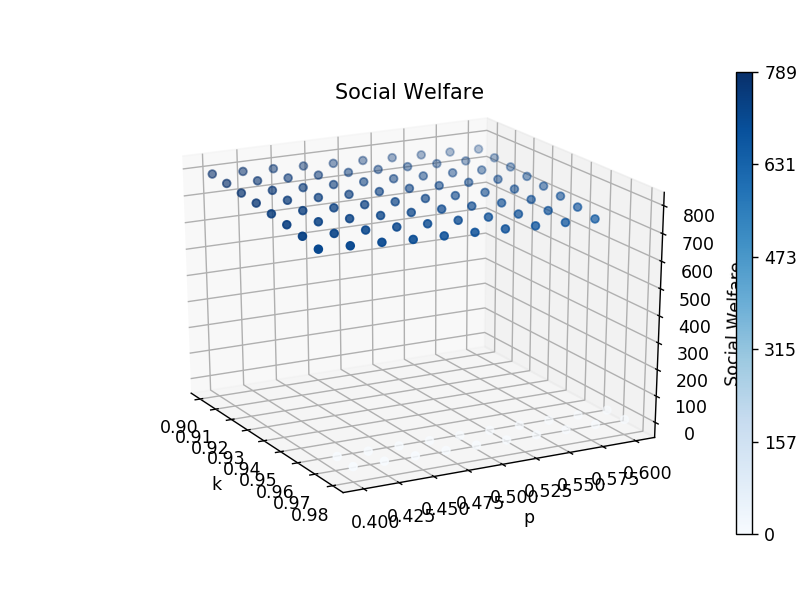

In [8]:
import numpy as np  # 用来处理数据
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.colors 
import matplotlib.ticker
import matplotlib as mpl

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

%matplotlib notebook

fig = plt.figure()
min_v = min(plotSocialWelfare)
max_v = max(plotSocialWelfare)
color = [plt.get_cmap("Blues", 100)(int(float(i-min_v)/(max_v-min_v)*100)) for i in plotSocialWelfare]

 
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
plt.set_cmap(plt.get_cmap("Blues", 100))
ax.set_title('Social Welfare')  # 设置本图名称
im=ax.scatter(kk,pp,plotSocialWelfare,c =color)   # 绘制数据点 c: 'r'红色，'y'黄色，等颜色
ax.view_init(elev=33, azim=63)
# fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)))

ax.set_xlabel('k')  # 设置x坐标轴
ax.set_ylabel('p')  # 设置y坐标轴
ax.set_zlabel('Social Welfare')  # 设置z坐标轴

cax = add_right_cax(ax, pad=0.02, width=0.02)
cbar = fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)),cax=cax)
# plt.savefig('SocialWelfare.pdf')
plt.show()

In [16]:
for i in range(0,10,1):
    for j in range(10,20,1):
        if j==18:
            break
        print(j)
    print('i',i)

10
11
12
13
14
15
16
17
i 0
10
11
12
13
14
15
16
17
i 1
10
11
12
13
14
15
16
17
i 2
10
11
12
13
14
15
16
17
i 3
10
11
12
13
14
15
16
17
i 4
10
11
12
13
14
15
16
17
i 5
10
11
12
13
14
15
16
17
i 6
10
11
12
13
14
15
16
17
i 7
10
11
12
13
14
15
16
17
i 8
10
11
12
13
14
15
16
17
i 9


# 把p的值放到0.1到0.4试一下

In [14]:
import numpy as np

kmin=0.9
kmax=0.9
pmin=0.1
pmax=0.4
kk=np.linspace(kmin,kmax,10)#行向量
pp=np.linspace(pmin,pmax,10)

kk=kk.reshape((10,1))
pp=pp.reshape((10,1))
# print(kk,pp)
ones=np.ones((10,1))
#print(ones)
# kk=np.dot(ones,kk)
# pp=np.dot(ones,pp)
# print(k)
# kk=np.transpose(kk)
# kk=kk.reshape((100,1))
# pp=pp.reshape((100,1))
# # print(k)
Parameter=np.hstack((kk,pp))
print(Parameter)
Welfare=np.zeros((10,1))
FirmWelfare=np.zeros((10,1))
SocialWelfare=np.zeros((10,1))

[[0.9        0.1       ]
 [0.9        0.13333333]
 [0.9        0.16666667]
 [0.9        0.2       ]
 [0.9        0.23333333]
 [0.9        0.26666667]
 [0.9        0.3       ]
 [0.9        0.33333333]
 [0.9        0.36666667]
 [0.9        0.4       ]]


In [15]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy

for i in range(0,10,1):
    BBBB=200;
    k=Parameter[i,0];
    p=Parameter[i,1];
    for count in range(0,50,1):
        gamma=0.9;
        epsilon=-0.3;

        rho=0.9;
        C=50;

        a=0.8;
        eta=0.6;
        xmean=a/eta;
        sigma=0.8;
        sd=sigma**2/2/eta
        xmin=xmean-2*sd
        xmax=xmean+2*sd

        I=1000;
        hmin=0.0001;
        hmax=100;
        h=np.linspace(hmin,hmax,I);   #列向量  
                                      #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
        h=h.reshape(I,1);
        #print(h);
        dh=(hmax-hmin)/(I-1);

        J=7;
        x=np.linspace(xmin,xmax,J);    # 行向量
        x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
        dx=(xmax-xmin)/(J-1);
        dx2=dx**2;

        hh=np.dot(h,np.ones((1,J)));
        xx=np.dot(np.ones((I,1)),x);

        mu=a-x*eta+BBBB;      
        s2=0.5*sigma**2;

        Vhf = np.zeros((I,J));
        Vhb = np.zeros((I,J));
        Vxf = np.zeros((I,J));
        Vxb = np.zeros((I,J));
        Vxx = np.zeros((I,J));
        n = np.zeros((I,J));

        chi =  - np.minimum(mu,0)/dx + s2/dx2;              
        yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
        zeta = np.maximum(mu,0)/dx + s2/dx2;

        maxit=100;
        crit=10**(-6);
        Delta=1000;

        updiag=np.zeros((I,1));
        for j in range(0,J,1):
            gg=np.tile(zeta[0][j],(I,1));
            updiag=np.vstack([updiag,gg]);

        centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
        for j in range(1,J-1,1):
            gg=np.tile(yy[0][j],(I,1));
            centdiag=np.vstack([centdiag,gg]);
        gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
        centdiag=np.vstack([centdiag,gg])

        lowdiag=np.tile(chi[0][1],(I,1));
        for j in range(2,J,1):
            gg=np.tile(chi[0][j],(I,1));
            lowdiag=np.vstack([lowdiag,gg]);

        centdiag=np.transpose(centdiag);
        Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
        lowdiag=np.transpose(lowdiag);
        Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
        updiag=np.transpose(updiag);
        Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
        Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

        v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
        v=v0;

        maxit=30;
        distm=np.zeros(maxit);
        for m in range(0,maxit,1):   
            V=copy.deepcopy(v);
            Vhf=np.zeros((I,J));
            Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
            Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;

            Vhb=np.zeros((I,J));
            Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
            Vhb[0,:]=(V[1,:]-V[0,:])/dh;

            I_concave=(Vhb>Vhf)+0;

            nf=((1-k)/C*Vhf)**epsilon;
            hf=(1-k)*nf-p*hh;

            nb=((1-k)/C*Vhb)**epsilon;
            hb=(1-k)*nb-p*hh;

            n0=p/(1-k)*hh;
            Vh0=C/(1-k)*n0**(1/epsilon);

            If=(hf>0)+0;
            Ib=(hb<0)+0;

            I0=(1-If-Ib);

            Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

            n=((1-k)/C*Vh_Upwind)**epsilon;
            u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);

            aaa=np.nan_to_num(hf,nan=0)
            hf=aaa
            aaa=np.nan_to_num(hb,nan=0)
            hb=aaa

            X=-np.minimum(hb,0)/dh;
            Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
            Z=np.maximum(hf,0)/dh;

            updiag=0;
            for j in range(0,J,1):
                pp=Z[0:I-1,j];
                pp=pp.reshape(I-1,1)
                gg=np.vstack([pp,0]);
                updiag=np.vstack([updiag,gg]);

            Y=np.transpose(Y);
            centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

            lowdiag=X[1:I,0];
            lowdiag=lowdiag.reshape(I-1,1);
            for j in range(1,J,1):
                pp=X[1:I,j];
                pp=pp.reshape(I-1,1);
                gg=np.vstack([0,pp]);
                lowdiag=np.vstack([lowdiag,gg]);

            centdiag=np.transpose(centdiag);
            AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();

            lowdiag=np.vstack([lowdiag,0]);
            lowdiag=np.transpose(lowdiag);
            AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();

            updiag=np.vstack([updiag,0]);
            updiag=np.transpose(updiag);
            AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();

            AA=AA_centdiag+AA_lowdiag+AA_updiag;

            A=AA+Bswitch;

            if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
                print("Improper Transition Matrix")
                break;

            B=(1/Delta+rho)*identity(I*J).toarray()-A;
            invB=np.linalg.inv(B);

            u=np.transpose(u);
            u_stacked=copy.deepcopy(u.reshape(I*J,1));
            V=np.transpose(V);
            V_stacked=copy.deepcopy(V.reshape(I*J,1));


            b=u_stacked+V_stacked/Delta;

            invBcopy=copy.deepcopy(invB);

            bcopy=np.tile(np.transpose(b),(I*J,1))
            index=np.where(np.isnan(bcopy))
        #     for i in range(0,len(index[0]),1):
        #         if invBcopy[index[0][i],index[1][i]]==0:
        #             bcopy[index[0][i],index[1][i]]=0

        #     index=np.where(np.isinf(bcopy))
        #     for i in range(0,len(index[0]),1):
        #         if invBcopy[index[0][i],index[1][i]]==0:
        #             bcopy[index[0][i],index[1][i]]=0

            V_stacked2=invBcopy*bcopy
            V_stacked2=V_stacked2.sum(axis=1)
            V_stacked2=V_stacked2.reshape(I*J,1)


            V=copy.deepcopy(V_stacked2.reshape(J,I));
            V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

            Vchange=V-v;

            v=copy.deepcopy(V);

            Vchangecopy=copy.deepcopy(Vchange)
            aaa=np.nan_to_num(Vchangecopy,nan=0,posinf=0,neginf=0)  
            Vchangecopy=aaa

            distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
            print(distm[m]);
            print(m);
            if distm[m]<crit:
                print("Value Function Converged, Iteration =",m,distm[m]);
                break;

        AT=np.transpose(A)
        b5=np.zeros((I*J,1))
        i_fix=5
        b5[i_fix-1,0]=0.1
        row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
        AT[i_fix-1,:]=row
        invAT=np.linalg.inv(AT);
        gg=np.dot(invAT,b5);

        g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

        gg=gg/g_sum
        # g=np.transpose(gg).reshape(I,J)
        ggcopy=copy.deepcopy(gg)
        # ggcopy=np.transpose(ggcopy)
        g=ggcopy.reshape(J,I)
        g=np.transpose(g)

        T=k*n+p*hh

        Tg=T*g
        TFW1=np.dot(np.ones((1,I)),Tg)
        TotalFirmWelfare=np.dot(TFW1,np.ones((J,1)))
    #     print('k=',k,'p=',p,'FirmWelfare=',TotalFirmWelfare)
    #     FirmWelfare[i,0]=TotalFirmWelfare

        Vg=V*g
        TSW1=np.dot(np.ones((1,I)),Vg)
        TotalSocialWelfare=np.dot(TSW1,np.ones((J,1)))

        # D=TotalSocialWelfare-TotalFirmWelfare

        # print('次数=',i,'k=',k,'p=',p,'TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'作差=',D)
        print('TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'BBBB',BBBB)
        if abs(BBBB-TotalFirmWelfare)<0.5:
            print('求B的次数',count+1,'第几组k和p',i+1,'最后迭代出的B值',BBBB)
            break
        elif BBBB>TotalFirmWelfare:
            BBBB=TotalFirmWelfare+0.5
        elif BBBB<TotalFirmWelfare:
            BBBB=TotalFirmWelfare-0.5

#         Welfare[i,0]=D
        SocialWelfare[i,0]=TotalSocialWelfare
        FirmWelfare[i,0]=TotalFirmWelfare

36.98440383332078
0
0.8465367220487181
1
0.023519773926935272
2
2.565037974378015e-05
3
8.106990634360045e-09
4
Value Function Converged, Iteration = 4 8.106990634360045e-09
TSW= [[936.43633941]] TFW= [[252.04769244]] BBBB 200
37.03270941530389
0
0.8466053229270329
1
0.023519163891016603
2
2.564456594811304e-05
3
8.105946136538478e-09
4
Value Function Converged, Iteration = 4 8.105946136538478e-09
TSW= [[936.56083651]] TFW= [[252.03731696]] BBBB [[251.54769244]]
求B的次数 2 第几组k和p 1 最后迭代出的B值 [[251.54769244]]
36.83465870281579
0
0.8527497883854664
1
0.02383815634441433
2
2.6279942822782232e-05
3
8.306560772552984e-09
4
Value Function Converged, Iteration = 4 8.306560772552984e-09
TSW= [[902.69542731]] TFW= [[230.01609154]] BBBB 200
36.864945234770495
0
0.852793297707013
1
0.02383777261951181
2
2.627614718875293e-05
3
8.305878651526655e-09
4
Value Function Converged, Iteration = 4 8.305878651526655e-09
TSW= [[902.77073681]] TFW= [[230.01014828]] BBBB [[229.51609154]]
求B的次数 2 第几组k和p 2 最后迭代出的B

In [16]:
print(FirmWelfare)
print("--------------------------------")
print(SocialWelfare)
print("--------------------------------")

[[252.04769244]
 [230.01609154]
 [214.07213522]
 [203.13976941]
 [193.92906448]
 [186.5668835 ]
 [181.12920358]
 [175.35981011]
 [171.38890987]
 [167.7883831 ]]
--------------------------------
[[936.43633941]
 [902.69542731]
 [877.50251863]
 [858.04210544]
 [841.88646217]
 [828.33607567]
 [816.90205514]
 [806.52245751]
 [797.65683497]
 [789.68626229]]
--------------------------------


## 画图

### 设置参数 

In [14]:
Parameter=[[0.9,0.1       ],
[0.9,0.13333333],
[0.9,0.16666667],
[0.9,0.2       ],
[0.9,0.23333333],
[0.9,0.26666667],
[0.9,0.3       ],
[0.9,0.33333333],
[0.9,0.36666667],
[0.9,0.4       ],
[0.9,0.4],
[0.9,0.42222222],
[0.9,0.44444444],
[0.9,0.46666667],
[0.9,0.48888889],
[0.9,0.51111111],
[0.9,0.53333333],
[0.9,0.55555556],
[0.9,0.57777778],
[0.9,0.6],
[0.90888889,0.4],
[0.90888889,0.42222222],
[0.90888889,0.44444444],
[0.90888889,0.46666667],
[0.90888889,0.48888889],
[0.90888889,0.51111111],
[0.90888889,0.53333333],
[0.90888889,0.55555556],
[0.90888889,0.57777778],
[0.90888889,0.6],
[0.91777778,0.4],
[0.91777778,0.42222222],
[0.91777778,0.44444444],
[0.91777778,0.46666667],
[0.91777778,0.48888889],
[0.91777778,0.51111111],
[0.91777778,0.53333333],
[0.91777778,0.55555556],
[0.91777778,0.57777778],
[0.91777778,0.6],
[0.92666667,0.4],
[0.92666667,0.42222222],
[0.92666667,0.44444444],
[0.92666667,0.46666667],
[0.92666667,0.48888889],
[0.92666667,0.51111111],
[0.92666667,0.53333333],
[0.92666667,0.55555556],
[0.92666667,0.57777778],
[0.92666667,0.6],
[0.93555556,0.4],
[0.93555556,0.42222222],
[0.93555556,0.44444444],
[0.93555556,0.46666667],
[0.93555556,0.48888889],
[0.93555556,0.51111111],
[0.93555556,0.53333333],
[0.93555556,0.55555556],
[0.93555556,0.57777778],
[0.93555556,0.6],
[0.94444444,0.4],
[0.94444444,0.42222222],
[0.94444444,0.44444444],
[0.94444444,0.46666667],
[0.94444444,0.48888889],
[0.94444444,0.51111111],
[0.94444444,0.53333333],
[0.94444444,0.55555556],
[0.94444444,0.57777778],
[0.94444444,0.6],
[0.95333333,0.4],
[0.95333333,0.42222222],
[0.95333333,0.44444444],
[0.95333333,0.46666667],
[0.95333333,0.48888889],
[0.95333333,0.51111111],
[0.95333333,0.53333333],
[0.95333333,0.55555556],
[0.95333333,0.57777778],
[0.95333333,0.6],
[0.96222222,0.4],
[0.96222222,0.42222222],
[0.96222222,0.44444444],
[0.96222222,0.46666667],
[0.96222222,0.48888889],
[0.96222222,0.51111111],
[0.96222222,0.53333333],
[0.96222222,0.55555556],
[0.96222222,0.57777778],
[0.96222222,0.6],
[0.97111111,0.4],
[0.97111111,0.42222222],
[0.97111111,0.44444444],
[0.97111111,0.46666667],
[0.97111111,0.48888889],
[0.97111111,0.51111111],
[0.97111111,0.53333333],
[0.97111111,0.55555556],
[0.97111111,0.57777778],
[0.97111111,0.6],
[0.98,0.4],
[0.98,0.42222222],
[0.98,0.44444444],
[0.98,0.46666667],
[0.98,0.48888889],
[0.98,0.51111111],
[0.98,0.53333333],
[0.98,0.55555556],
[0.98,0.57777778],
[0.98,0.6]]
Parameter=np.array(Parameter)
kk=Parameter[:,0]
pp=Parameter[:,1]
kk=kk.flatten()
pp=pp.flatten()

# print(kk,pp)

In [12]:
plotFirmWelfare=[[252.04769244],
 [230.01609154],
 [214.07213522],
 [203.13976941],
 [193.92906448],
 [186.5668835 ],
 [181.12920358],
 [175.35981011],
 [171.38890987],
 [167.7883831 ],
 [167.7883831 ],
 [165.76689181],
 [164.71635902],
 [162.66898961],
 [159.81552762],
 [159.11232217],
 [157.41369683],
 [155.67304992],
 [154.62077331],
 [154.20658241],
 [168.24795554],
 [165.62501142],
 [164.481072  ],
 [163.54832461],
 [160.34935092],
 [160.22014465],
 [157.54980098],
 [157.63732588],
 [154.28721515],
 [154.97961528],
 [169.93867632],
 [166.99877843],
 [164.16085334],
 [164.56609945],
 [160.94911371],
 [161.44936431],
 [157.66162584],
 [158.39099113],
 [154.5055569 ],
 [154.50332533],
 [171.02750256],
 [168.6317185 ],
 [164.95197962],
 [165.70965248],
 [161.63240195],
 [162.40393178],
 [157.73241359],
 [158.46210635],
 [157.15653101],
 [153.8196192 ],
 [169.75104714],
 [170.49427724],
 [166.38946167],
 [165.96609867],
 [162.42460611],
 [163.19991741],
 [158.39875977],
 [158.46296312],
 [159.18490266],
 [155.21814465],
 [172.21991115],
 [169.16581232],
 [168.17127864],
 [166.02676339],
 [163.36416021],
 [164.14395634],
 [160.13720604],
 [158.34054048],
 [159.06192227],
 [159.4908041 ],
 [175.42366809],
 [169.61493226],
 [170.46515038],
 [165.84113666],
 [164.51289785],
 [165.29817732],
 [162.33484548],
 [157.99005017],
 [158.70983517],
 [159.42208284],
 [172.52010183],
 [172.71185586],
 [172.65947615],
 [165.38708586],
 [165.97874144],
 [166.77101748],
 [165.10700853],
 [159.21896999],
 [157.8955996 ],
 [158.6041932 ],
 [176.35464039],
 [177.2536638 ],
 [170.60333292],
 [167.16206964],
 [167.97289669],
 [168.77469198],
 [168.6729857 ],
 [162.24135893],
 [157.17022789],
 [156.70372441],
 [183.00399442],
 [173.74646504],
 [169.32654682],
 [170.16137043],
 [170.98674573],
 [171.80292742],
 [172.61015942],
 [165.57023725],
 [159.62399311],
 [154.93542151]]

plotFirmWelfare=np.array(plotFirmWelfare)
plotFirmWelfare=plotFirmWelfare.flatten()
plotSocialWelfare=[[936.43633941],
 [902.69542731],
 [877.50251863],
 [858.04210544],
 [841.88646217],
 [828.33607567],
 [816.90205514],
 [806.52245751],
 [797.65683497],
 [789.68626229],
 [789.68626229],
 [784.84036674],
 [780.54023824],
 [776.13138186],
 [771.69516216],
 [768.13922174],
 [764.36932955],
 [760.82591296],
 [757.53143153],
 [754.64671181],
 [782.58478735],
 [777.59686563],
 [773.33731575],
 [769.30560999],
 [764.80174515],
 [761.44984916],
 [757.4236058 ],
 [754.44489323],
 [750.52050288],
 [747.93459789],
 [775.21510678],
 [770.16945535],
 [765.42975616],
 [761.86149673],
 [757.27129172],
 [754.13127054],
 [749.8282183 ],
 [747.03416014],
 [743.06376298],
 [740.25038704],
 [766.86319763],
 [762.01144182],
 [757.05051105],
 [753.65245068],
 [748.96496253],
 [745.93024128],
 [741.44008127],
 [738.64894806],
 [735.50673324],
 [731.76393524],
 [756.72158685],
 [752.92064989],
 [747.86147712],
 [744.19629918],
 [739.69152821],
 [736.69123143],
 [732.26290215],
 [729.27050631],
 [726.68414519],
 [722.9644961 ],
 [746.40869958],
 [741.59267283],
 [737.47868157],
 [733.39963972],
 [729.17663824],
 [726.21645017],
 [722.13481052],
 [718.61228072],
 [716.02125129],
 [713.54437184],
 [734.59612826],
 [728.97183158],
 [725.52237299],
 [720.80682468],
 [717.00524069],
 [714.09305825],
 [710.41888478],
 [706.23790862],
 [703.63344729],
 [701.21256617],
 [718.56935048],
 [714.69974444],
 [711.16159646],
 [705.6789075 ],
 [702.50244759],
 [699.64992294],
 [696.42941734],
 [692.02093945],
 [688.79472291],
 [686.34461228],
 [700.61608295],
 [697.1705594 ],
 [691.99311803],
 [687.47678033],
 [684.45000771],
 [681.6758766 ],
 [678.93103039],
 [674.69632657],
 [670.5106467 ],
 [667.6392282 ],
 [677.25534622],
 [671.32269412],
 [666.3341299 ],
 [663.15207879],
 [660.24833085],
 [657.58695574],
 [655.13799306],
 [651.1407938 ],
 [647.00692268],
 [642.95161387]]

plotSocialWelfare=np.array(plotSocialWelfare)
# print(np.transpose(plotSocialWelfare))
plotSocialWelfare=plotSocialWelfare.flatten()

### 画出图像 

<IPython.core.display.Javascript object>


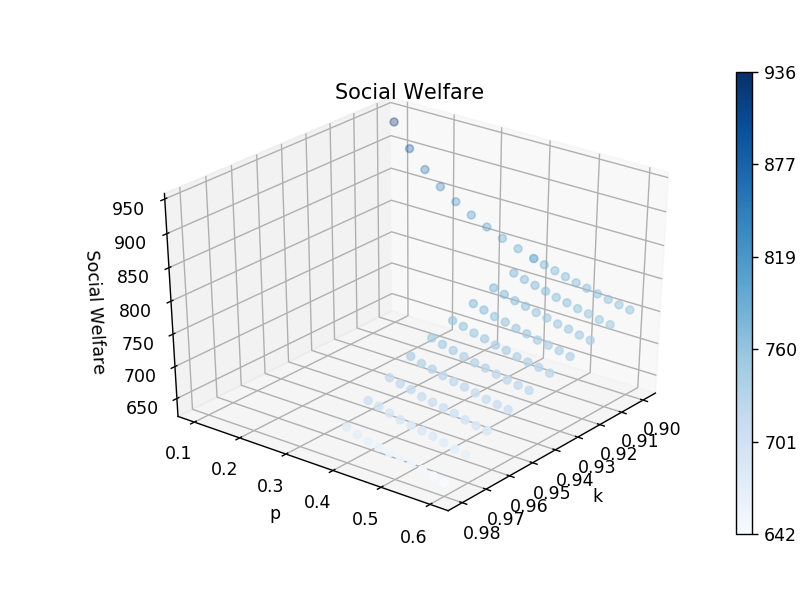

In [15]:
import numpy as np  # 用来处理数据
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.colors 
import matplotlib.ticker
import matplotlib as mpl

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

%matplotlib notebook

fig = plt.figure()
min_v = min(plotSocialWelfare)
max_v = max(plotSocialWelfare)
color = [plt.get_cmap("Blues", 100)(int(float(i-min_v)/(max_v-min_v)*100)) for i in plotSocialWelfare]

 
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
plt.set_cmap(plt.get_cmap("Blues", 100))
ax.set_title('Social Welfare')  # 设置本图名称
im=ax.scatter(kk,pp,plotSocialWelfare,c =color)   # 绘制数据点 c: 'r'红色，'y'黄色，等颜色
ax.view_init(elev=33, azim=63)
# fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)))

ax.set_xlabel('k')  # 设置x坐标轴
ax.set_ylabel('p')  # 设置y坐标轴
ax.set_zlabel('Social Welfare')  # 设置z坐标轴

cax = add_right_cax(ax, pad=0.02, width=0.02)
cbar = fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)),cax=cax)
# plt.savefig('SocialWelfare.pdf')
plt.show()

<IPython.core.display.Javascript object>


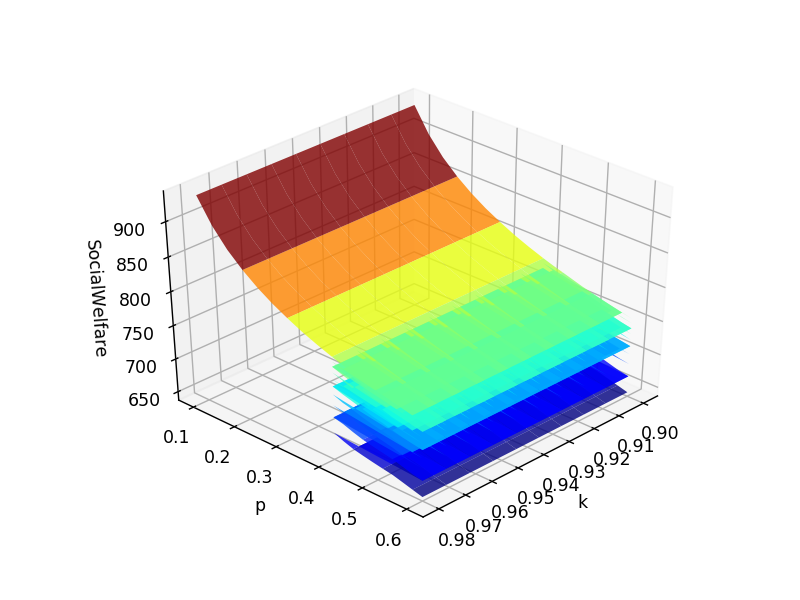

In [20]:
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
plotSocialWelfare=[[936.43633941],
 [902.69542731],
 [877.50251863],
 [858.04210544],
 [841.88646217],
 [828.33607567],
 [816.90205514],
 [806.52245751],
 [797.65683497],
 [789.68626229],
 [789.68626229],
 [784.84036674],
 [780.54023824],
 [776.13138186],
 [771.69516216],
 [768.13922174],
 [764.36932955],
 [760.82591296],
 [757.53143153],
 [754.64671181],
 [782.58478735],
 [777.59686563],
 [773.33731575],
 [769.30560999],
 [764.80174515],
 [761.44984916],
 [757.4236058 ],
 [754.44489323],
 [750.52050288],
 [747.93459789],
 [775.21510678],
 [770.16945535],
 [765.42975616],
 [761.86149673],
 [757.27129172],
 [754.13127054],
 [749.8282183 ],
 [747.03416014],
 [743.06376298],
 [740.25038704],
 [766.86319763],
 [762.01144182],
 [757.05051105],
 [753.65245068],
 [748.96496253],
 [745.93024128],
 [741.44008127],
 [738.64894806],
 [735.50673324],
 [731.76393524],
 [756.72158685],
 [752.92064989],
 [747.86147712],
 [744.19629918],
 [739.69152821],
 [736.69123143],
 [732.26290215],
 [729.27050631],
 [726.68414519],
 [722.9644961 ],
 [746.40869958],
 [741.59267283],
 [737.47868157],
 [733.39963972],
 [729.17663824],
 [726.21645017],
 [722.13481052],
 [718.61228072],
 [716.02125129],
 [713.54437184],
 [734.59612826],
 [728.97183158],
 [725.52237299],
 [720.80682468],
 [717.00524069],
 [714.09305825],
 [710.41888478],
 [706.23790862],
 [703.63344729],
 [701.21256617],
 [718.56935048],
 [714.69974444],
 [711.16159646],
 [705.6789075 ],
 [702.50244759],
 [699.64992294],
 [696.42941734],
 [692.02093945],
 [688.79472291],
 [686.34461228],
 [700.61608295],
 [697.1705594 ],
 [691.99311803],
 [687.47678033],
 [684.45000771],
 [681.6758766 ],
 [678.93103039],
 [674.69632657],
 [670.5106467 ],
 [667.6392282 ],
 [677.25534622],
 [671.32269412],
 [666.3341299 ],
 [663.15207879],
 [660.24833085],
 [657.58695574],
 [655.13799306],
 [651.1407938 ],
 [647.00692268],
 [642.95161387]]
plotSocialWelfare=np.array(plotSocialWelfare)
fig = plt.figure()


Xl,Yl = np.meshgrid(kk,pp)

# color = [plt.get_cmap("seismic", 100)(int(float(i-min_ncut)/(max_ncut-min_ncut)*100)) for i in ncut]
# plt.set_cmap(plt.get_cmap("seismic", 100))
ax = plt.axes(projection='3d')
ax.view_init(elev=22, azim=-123)
ax.plot_surface(Xl,Yl,plotSocialWelfare,cmap='jet',alpha=0.8)
ax.set_xlabel('k')
ax.set_ylabel('p')
ax.set_zlabel('SocialWelfare')
# plt.scatter(Xl, Yl, ncut, c=(Xl+Yl+ncut)/3)"Xl+Yl+ncut)/3
# plt.savefig('figure3.3.pdf')
plt.show()

# 把当p等于0.1-0.4时的k值补一下

In [23]:
import numpy as np

kmin=0.9
kmax=0.98
pmin=0.1
pmax=0.4
kk=np.linspace(kmin,kmax,5)#行向量
pp=np.linspace(pmin,pmax,5)

kk=kk.reshape((1,5))
pp=pp.reshape((1,5))
# print(kk,pp)
ones=np.ones((5,1))
#print(ones)
kk=np.dot(ones,kk)
pp=np.dot(ones,pp)
# print(k)
kk=np.transpose(kk)
kk=kk.reshape((25,1))
pp=pp.reshape((25,1))
# # print(k)
Parameter=np.hstack((kk,pp))
print(Parameter)
Welfare=np.zeros((25,1))
FirmWelfare=np.zeros((25,1))
SocialWelfare=np.zeros((25,1))

[[0.9   0.1  ]
 [0.9   0.175]
 [0.9   0.25 ]
 [0.9   0.325]
 [0.9   0.4  ]
 [0.92  0.1  ]
 [0.92  0.175]
 [0.92  0.25 ]
 [0.92  0.325]
 [0.92  0.4  ]
 [0.94  0.1  ]
 [0.94  0.175]
 [0.94  0.25 ]
 [0.94  0.325]
 [0.94  0.4  ]
 [0.96  0.1  ]
 [0.96  0.175]
 [0.96  0.25 ]
 [0.96  0.325]
 [0.96  0.4  ]
 [0.98  0.1  ]
 [0.98  0.175]
 [0.98  0.25 ]
 [0.98  0.325]
 [0.98  0.4  ]]


In [24]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy

for i in range(0,25,1):
    BBBB=200;
    k=Parameter[i,0];
    p=Parameter[i,1];
    for count in range(0,50,1):
        gamma=0.9;
        epsilon=-0.3;

        rho=0.9;
        C=50;

        a=0.8;
        eta=0.6;
        xmean=a/eta;
        sigma=0.8;
        sd=sigma**2/2/eta
        xmin=xmean-2*sd
        xmax=xmean+2*sd

        I=1000;
        hmin=0.0001;
        hmax=100;
        h=np.linspace(hmin,hmax,I);   #列向量  
                                      #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
        h=h.reshape(I,1);
        #print(h);
        dh=(hmax-hmin)/(I-1);

        J=7;
        x=np.linspace(xmin,xmax,J);    # 行向量
        x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
        dx=(xmax-xmin)/(J-1);
        dx2=dx**2;

        hh=np.dot(h,np.ones((1,J)));
        xx=np.dot(np.ones((I,1)),x);

        mu=a-x*eta+BBBB;      
        s2=0.5*sigma**2;

        Vhf = np.zeros((I,J));
        Vhb = np.zeros((I,J));
        Vxf = np.zeros((I,J));
        Vxb = np.zeros((I,J));
        Vxx = np.zeros((I,J));
        n = np.zeros((I,J));

        chi =  - np.minimum(mu,0)/dx + s2/dx2;              
        yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
        zeta = np.maximum(mu,0)/dx + s2/dx2;

        maxit=100;
        crit=10**(-6);
        Delta=1000;

        updiag=np.zeros((I,1));
        for j in range(0,J,1):
            gg=np.tile(zeta[0][j],(I,1));
            updiag=np.vstack([updiag,gg]);

        centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
        for j in range(1,J-1,1):
            gg=np.tile(yy[0][j],(I,1));
            centdiag=np.vstack([centdiag,gg]);
        gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
        centdiag=np.vstack([centdiag,gg])

        lowdiag=np.tile(chi[0][1],(I,1));
        for j in range(2,J,1):
            gg=np.tile(chi[0][j],(I,1));
            lowdiag=np.vstack([lowdiag,gg]);

        centdiag=np.transpose(centdiag);
        Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
        lowdiag=np.transpose(lowdiag);
        Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
        updiag=np.transpose(updiag);
        Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
        Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

        v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
        v=v0;

        maxit=30;
        distm=np.zeros(maxit);
        for m in range(0,maxit,1):   
            V=copy.deepcopy(v);
            Vhf=np.zeros((I,J));
            Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
            Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;

            Vhb=np.zeros((I,J));
            Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
            Vhb[0,:]=(V[1,:]-V[0,:])/dh;

            I_concave=(Vhb>Vhf)+0;

            nf=((1-k)/C*Vhf)**epsilon;
            hf=(1-k)*nf-p*hh;

            nb=((1-k)/C*Vhb)**epsilon;
            hb=(1-k)*nb-p*hh;

            n0=p/(1-k)*hh;
            Vh0=C/(1-k)*n0**(1/epsilon);

            If=(hf>0)+0;
            Ib=(hb<0)+0;

            I0=(1-If-Ib);

            Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

            n=((1-k)/C*Vh_Upwind)**epsilon;
            u=xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);

            aaa=np.nan_to_num(hf,nan=0)
            hf=aaa
            aaa=np.nan_to_num(hb,nan=0)
            hb=aaa

            X=-np.minimum(hb,0)/dh;
            Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
            Z=np.maximum(hf,0)/dh;

            updiag=0;
            for j in range(0,J,1):
                pp=Z[0:I-1,j];
                pp=pp.reshape(I-1,1)
                gg=np.vstack([pp,0]);
                updiag=np.vstack([updiag,gg]);

            Y=np.transpose(Y);
            centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

            lowdiag=X[1:I,0];
            lowdiag=lowdiag.reshape(I-1,1);
            for j in range(1,J,1):
                pp=X[1:I,j];
                pp=pp.reshape(I-1,1);
                gg=np.vstack([0,pp]);
                lowdiag=np.vstack([lowdiag,gg]);

            centdiag=np.transpose(centdiag);
            AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();

            lowdiag=np.vstack([lowdiag,0]);
            lowdiag=np.transpose(lowdiag);
            AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();

            updiag=np.vstack([updiag,0]);
            updiag=np.transpose(updiag);
            AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();

            AA=AA_centdiag+AA_lowdiag+AA_updiag;

            A=AA+Bswitch;

            if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
                print("Improper Transition Matrix")
                break;

            B=(1/Delta+rho)*identity(I*J).toarray()-A;
            invB=np.linalg.inv(B);

            u=np.transpose(u);
            u_stacked=copy.deepcopy(u.reshape(I*J,1));
            V=np.transpose(V);
            V_stacked=copy.deepcopy(V.reshape(I*J,1));


            b=u_stacked+V_stacked/Delta;

            invBcopy=copy.deepcopy(invB);

            bcopy=np.tile(np.transpose(b),(I*J,1))
            index=np.where(np.isnan(bcopy))
        #     for i in range(0,len(index[0]),1):
        #         if invBcopy[index[0][i],index[1][i]]==0:
        #             bcopy[index[0][i],index[1][i]]=0

        #     index=np.where(np.isinf(bcopy))
        #     for i in range(0,len(index[0]),1):
        #         if invBcopy[index[0][i],index[1][i]]==0:
        #             bcopy[index[0][i],index[1][i]]=0

            V_stacked2=invBcopy*bcopy
            V_stacked2=V_stacked2.sum(axis=1)
            V_stacked2=V_stacked2.reshape(I*J,1)


            V=copy.deepcopy(V_stacked2.reshape(J,I));
            V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

            Vchange=V-v;

            v=copy.deepcopy(V);

            Vchangecopy=copy.deepcopy(Vchange)
            aaa=np.nan_to_num(Vchangecopy,nan=0,posinf=0,neginf=0)  
            Vchangecopy=aaa

            distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
            print(distm[m]);
            print(m);
            if distm[m]<crit:
                print("Value Function Converged, Iteration =",m,distm[m]);
                break;

        AT=np.transpose(A)
        b5=np.zeros((I*J,1))
        i_fix=5
        b5[i_fix-1,0]=0.1
        row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
        AT[i_fix-1,:]=row
        invAT=np.linalg.inv(AT);
        gg=np.dot(invAT,b5);

        g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

        gg=gg/g_sum
        # g=np.transpose(gg).reshape(I,J)
        ggcopy=copy.deepcopy(gg)
        # ggcopy=np.transpose(ggcopy)
        g=ggcopy.reshape(J,I)
        g=np.transpose(g)

        T=k*n+p*hh

        Tg=T*g
        TFW1=np.dot(np.ones((1,I)),Tg)
        TotalFirmWelfare=np.dot(TFW1,np.ones((J,1)))
    #     print('k=',k,'p=',p,'FirmWelfare=',TotalFirmWelfare)
    #     FirmWelfare[i,0]=TotalFirmWelfare

        Vg=V*g
        TSW1=np.dot(np.ones((1,I)),Vg)
        TotalSocialWelfare=np.dot(TSW1,np.ones((J,1)))

        # D=TotalSocialWelfare-TotalFirmWelfare

        # print('次数=',i,'k=',k,'p=',p,'TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'作差=',D)
        print('TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'BBBB',BBBB)
        if abs(BBBB-TotalFirmWelfare)<0.5:
            print('求B的次数',count+1,'第几组k和p',i+1,'最后迭代出的B值',BBBB)
            break
        elif BBBB>TotalFirmWelfare:
            BBBB=TotalFirmWelfare+0.5
        elif BBBB<TotalFirmWelfare:
            BBBB=TotalFirmWelfare-0.5

#         Welfare[i,0]=D
        SocialWelfare[i,0]=TotalSocialWelfare
        FirmWelfare[i,0]=TotalFirmWelfare

36.98440383332078
0
0.8465367220487181
1
0.023519773926935272
2
2.565037974378015e-05
3
8.106990634360045e-09
4
Value Function Converged, Iteration = 4 8.106990634360045e-09
TSW= [[936.43633941]] TFW= [[252.04769244]] BBBB 200
37.03270941530389
0
0.8466053229270329
1
0.023519163891016603
2
2.564456594811304e-05
3
8.105946136538478e-09
4
Value Function Converged, Iteration = 4 8.105946136538478e-09
TSW= [[936.56083651]] TFW= [[252.03731696]] BBBB [[251.54769244]]
求B的次数 2 第几组k和p 1 最后迭代出的B值 [[251.54769244]]
36.64920706743708
0
0.8605186439003703
1
0.02423360855068779
2
2.707072921737108e-05
3
8.558412645243152e-09
4
Value Function Converged, Iteration = 4 8.558412645243152e-09
TSW= [[872.19800975]] TFW= [[210.96696041]] BBBB 200
36.66090692924576
0
0.860535693634553
1
0.024233459726112017
2
2.7069191951056837e-05
3
8.558146191717242e-09
4
Value Function Converged, Iteration = 4 8.558146191717242e-09
TSW= [[872.22537706]] TFW= [[210.96264849]] BBBB [[210.46696041]]
求B的次数 2 第几组k和p 2 最后迭代出的B

0.0016189169878444432
2
8.960667656765509e-07
3
Value Function Converged, Iteration = 3 8.960667656765509e-07
TSW= [[798.55796697]] TFW= [[218.21848977]] BBBB 200
36.61021813668538
0
0.3281087866931607
1
0.0016188753022596813
2
8.96048248932857e-07
3
Value Function Converged, Iteration = 3 8.96048248932857e-07
TSW= [[798.60009426]] TFW= [[218.21492115]] BBBB [[217.71848977]]
求B的次数 2 第几组k和p 17 最后迭代出的B值 [[217.71848977]]
36.258956447335656
0
0.3366517529708588
1
0.0016854834351001102
2
9.398427955886746e-07
3
Value Function Converged, Iteration = 3 9.398427955886746e-07
TSW= [[765.00082873]] TFW= [[198.79711475]] BBBB 200
36.25812776529495
0
0.3366514900966955
1
0.0016854852604240023
2
9.398435949492523e-07
3
Value Function Converged, Iteration = 3 9.398435949492523e-07
TSW= [[764.99907907]] TFW= [[198.79725566]] BBBB [[199.29711475]]
求B的次数 2 第几组k和p 18 最后迭代出的B值 [[199.29711475]]
35.932665424923556
0
0.34518989668218936
1
0.0017510765404225026
2
9.831191327691613e-07
3
Value Function Conver

In [25]:
print(FirmWelfare)
print("--------------------------------")
print(SocialWelfare)
print("--------------------------------")

[[252.04769244]
 [210.96696041]
 [190.50853046]
 [177.50971134]
 [167.7883831 ]
 [254.59769741]
 [212.90832878]
 [191.34664395]
 [178.38677391]
 [170.11904491]
 [257.3565264 ]
 [216.13997989]
 [194.06534598]
 [179.89208355]
 [173.10402978]
 [262.33565643]
 [218.21848977]
 [198.79711475]
 [184.26144188]
 [176.74201023]
 [270.40245423]
 [227.38968441]
 [  0.        ]
 [191.17187464]
 [183.00399442]]
--------------------------------
[[936.43633941]
 [872.19800975]
 [834.99237125]
 [809.25495559]
 [789.68626229]
 [916.68487025]
 [853.72801845]
 [817.0053132 ]
 [791.86708785]
 [773.20418018]
 [891.65959505]
 [830.71832415]
 [794.89730529]
 [770.12538535]
 [752.41494345]
 [857.84483863]
 [798.55796697]
 [765.00082873]
 [741.13446453]
 [723.83338146]
 [802.79959446]
 [747.94933887]
 [  0.        ]
 [693.71100277]
 [677.25534622]]
--------------------------------


## 画图

### 设置参数

In [1]:
Parameter=[[0.9,   0.1  ],
 [0.9 ,  0.175],
 [0.9  , 0.25 ],
 [0.9   ,0.325],
 [0.9,   0.4  ],
 [0.92,  0.1  ],
 [0.92 , 0.175],
 [0.92  ,0.25 ],
 [0.92,  0.325],
 [0.92 , 0.4  ],
 [0.94  ,0.1  ],
 [0.94  ,0.175],
 [0.94 , 0.25 ],
 [0.94,  0.325],
 [0.94  ,0.4  ],
 [0.96 , 0.1  ],
 [0.96,  0.175],
 [0.96  ,0.25 ],
 [0.96,  0.325],
 [0.96 , 0.4  ],
 [0.98  ,0.1  ],
 [0.98  ,0.175],
 [0.98  ,0.25 ],
 [0.98 , 0.325],
 [0.98,  0.4  ],
[0.9,0.1       ],
[0.9,0.13333333],
[0.9,0.16666667],
[0.9,0.2       ],
[0.9,0.23333333],
[0.9,0.26666667],
[0.9,0.3       ],
[0.9,0.33333333],
[0.9,0.36666667],
[0.9,0.4       ],
[0.9,0.4],
[0.9,0.42222222],
[0.9,0.44444444],
[0.9,0.46666667],
[0.9,0.48888889],
[0.9,0.51111111],
[0.9,0.53333333],
[0.9,0.55555556],
[0.9,0.57777778],
[0.9,0.6],
[0.90888889,0.4],
[0.90888889,0.42222222],
[0.90888889,0.44444444],
[0.90888889,0.46666667],
[0.90888889,0.48888889],
[0.90888889,0.51111111],
[0.90888889,0.53333333],
[0.90888889,0.55555556],
[0.90888889,0.57777778],
[0.90888889,0.6],
[0.91777778,0.4],
[0.91777778,0.42222222],
[0.91777778,0.44444444],
[0.91777778,0.46666667],
[0.91777778,0.48888889],
[0.91777778,0.51111111],
[0.91777778,0.53333333],
[0.91777778,0.55555556],
[0.91777778,0.57777778],
[0.91777778,0.6],
[0.92666667,0.4],
[0.92666667,0.42222222],
[0.92666667,0.44444444],
[0.92666667,0.46666667],
[0.92666667,0.48888889],
[0.92666667,0.51111111],
[0.92666667,0.53333333],
[0.92666667,0.55555556],
[0.92666667,0.57777778],
[0.92666667,0.6],
[0.93555556,0.4],
[0.93555556,0.42222222],
[0.93555556,0.44444444],
[0.93555556,0.46666667],
[0.93555556,0.48888889],
[0.93555556,0.51111111],
[0.93555556,0.53333333],
[0.93555556,0.55555556],
[0.93555556,0.57777778],
[0.93555556,0.6],
[0.94444444,0.4],
[0.94444444,0.42222222],
[0.94444444,0.44444444],
[0.94444444,0.46666667],
[0.94444444,0.48888889],
[0.94444444,0.51111111],
[0.94444444,0.53333333],
[0.94444444,0.55555556],
[0.94444444,0.57777778],
[0.94444444,0.6],
[0.95333333,0.4],
[0.95333333,0.42222222],
[0.95333333,0.44444444],
[0.95333333,0.46666667],
[0.95333333,0.48888889],
[0.95333333,0.51111111],
[0.95333333,0.53333333],
[0.95333333,0.55555556],
[0.95333333,0.57777778],
[0.95333333,0.6],
[0.96222222,0.4],
[0.96222222,0.42222222],
[0.96222222,0.44444444],
[0.96222222,0.46666667],
[0.96222222,0.48888889],
[0.96222222,0.51111111],
[0.96222222,0.53333333],
[0.96222222,0.55555556],
[0.96222222,0.57777778],
[0.96222222,0.6],
[0.97111111,0.4],
[0.97111111,0.42222222],
[0.97111111,0.44444444],
[0.97111111,0.46666667],
[0.97111111,0.48888889],
[0.97111111,0.51111111],
[0.97111111,0.53333333],
[0.97111111,0.55555556],
[0.97111111,0.57777778],
[0.97111111,0.6],
[0.98,0.4],
[0.98,0.42222222],
[0.98,0.44444444],
[0.98,0.46666667],
[0.98,0.48888889],
[0.98,0.51111111],
[0.98,0.53333333],
[0.98,0.55555556],
[0.98,0.57777778],
[0.98,0.6]]

Parameter=np.array(Parameter)
kk=Parameter[:,0]
pp=Parameter[:,1]
kk=kk.flatten()
pp=pp.flatten()

plotFirmWelfare=[[252.04769244],
 [210.96696041],
 [190.50853046],
 [177.50971134],
 [167.7883831 ],
 [254.59769741],
 [212.90832878],
 [191.34664395],
 [178.38677391],
 [170.11904491],
 [257.3565264 ],
 [216.13997989],
 [194.06534598],
 [179.89208355],
 [173.10402978],
 [262.33565643],
 [218.21848977],
 [198.79711475],
 [184.26144188],
 [176.74201023],
 [270.40245423],
 [227.38968441],
 [  200.44816        ],
 [191.17187464],
 [183.00399442],
[252.04769244],
 [230.01609154],
 [214.07213522],
 [203.13976941],
 [193.92906448],
 [186.5668835 ],
 [181.12920358],
 [175.35981011],
 [171.38890987],
 [167.7883831 ],
[167.7883831 ],
 [165.76689181],
 [164.71635902],
 [162.66898961],
 [159.81552762],
 [159.11232217],
 [157.41369683],
 [155.67304992],
 [154.62077331],
 [154.20658241],
 [168.24795554],
 [165.62501142],
 [164.481072  ],
 [163.54832461],
 [160.34935092],
 [160.22014465],
 [157.54980098],
 [157.63732588],
 [154.28721515],
 [154.97961528],
 [169.93867632],
 [166.99877843],
 [164.16085334],
 [164.56609945],
 [160.94911371],
 [161.44936431],
 [157.66162584],
 [158.39099113],
 [154.5055569 ],
 [154.50332533],
 [171.02750256],
 [168.6317185 ],
 [164.95197962],
 [165.70965248],
 [161.63240195],
 [162.40393178],
 [157.73241359],
 [158.46210635],
 [157.15653101],
 [153.8196192 ],
 [169.75104714],
 [170.49427724],
 [166.38946167],
 [165.96609867],
 [162.42460611],
 [163.19991741],
 [158.39875977],
 [158.46296312],
 [159.18490266],
 [155.21814465],
 [172.21991115],
 [169.16581232],
 [168.17127864],
 [166.02676339],
 [163.36416021],
 [164.14395634],
 [160.13720604],
 [158.34054048],
 [159.06192227],
 [159.4908041 ],
 [175.42366809],
 [169.61493226],
 [170.46515038],
 [165.84113666],
 [164.51289785],
 [165.29817732],
 [162.33484548],
 [157.99005017],
 [158.70983517],
 [159.42208284],
 [172.52010183],
 [172.71185586],
 [172.65947615],
 [165.38708586],
 [165.97874144],
 [166.77101748],
 [165.10700853],
 [159.21896999],
 [157.8955996 ],
 [158.6041932 ],
[176.35464039],
 [177.2536638 ],
 [170.60333292],
 [167.16206964],
 [167.97289669],
 [168.77469198],
 [168.6729857 ],
 [162.24135893],
 [157.17022789],
 [156.70372441],
 [183.00399442],
 [173.74646504],
 [169.32654682],
 [170.16137043],
 [170.98674573],
 [171.80292742],
 [172.61015942],
 [165.57023725],
 [159.62399311],
 [154.93542151]]

plotFirmWelfare=np.array(plotFirmWelfare)
plotFirmWelfare=plotFirmWelfare.flatten()
plotSocialWelfare=[[936.43633941],
 [872.19800975],
 [834.99237125],
 [809.25495559],
 [789.68626229],
 [916.68487025],
 [853.72801845],
 [817.0053132 ],
 [791.86708785],
 [773.20418018],
 [891.65959505],
 [830.71832415],
 [794.89730529],
 [770.12538535],
 [752.41494345],
 [857.84483863],
 [798.55796697],
 [765.00082873],
 [741.13446453],
 [723.83338146],
 [802.79959446],
 [747.94933887],
 [  714.52549       ],
 [693.71100277],
 [677.25534622],
[936.43633941],
 [902.69542731],
 [877.50251863],
 [858.04210544],
 [841.88646217],
 [828.33607567],
 [816.90205514],
 [806.52245751],
 [797.65683497],
 [789.68626229],
[789.68626229],
 [784.84036674],
 [780.54023824],
 [776.13138186],
 [771.69516216],
 [768.13922174],
 [764.36932955],
 [760.82591296],
 [757.53143153],
 [754.64671181],
 [782.58478735],
 [777.59686563],
 [773.33731575],
 [769.30560999],
 [764.80174515],
 [761.44984916],
 [757.4236058 ],
 [754.44489323],
 [750.52050288],
 [747.93459789],
 [775.21510678],
 [770.16945535],
 [765.42975616],
 [761.86149673],
 [757.27129172],
 [754.13127054],
 [749.8282183 ],
 [747.03416014],
 [743.06376298],
 [740.25038704],
 [766.86319763],
 [762.01144182],
 [757.05051105],
 [753.65245068],
 [748.96496253],
 [745.93024128],
 [741.44008127],
 [738.64894806],
 [735.50673324],
 [731.76393524],
 [756.72158685],
 [752.92064989],
 [747.86147712],
 [744.19629918],
 [739.69152821],
 [736.69123143],
 [732.26290215],
 [729.27050631],
 [726.68414519],
 [722.9644961 ],
 [746.40869958],
 [741.59267283],
 [737.47868157],
 [733.39963972],
 [729.17663824],
 [726.21645017],
 [722.13481052],
 [718.61228072],
 [716.02125129],
 [713.54437184],
 [734.59612826],
 [728.97183158],
 [725.52237299],
 [720.80682468],
 [717.00524069],
 [714.09305825],
 [710.41888478],
 [706.23790862],
 [703.63344729],
 [701.21256617],
 [718.56935048],
 [714.69974444],
 [711.16159646],
 [705.6789075 ],
 [702.50244759],
 [699.64992294],
 [696.42941734],
 [692.02093945],
 [688.79472291],
 [686.34461228],
[700.61608295],
 [697.1705594 ],
 [691.99311803],
 [687.47678033],
 [684.45000771],
 [681.6758766 ],
 [678.93103039],
 [674.69632657],
 [670.5106467 ],
 [667.6392282 ],
 [677.25534622],
 [671.32269412],
 [666.3341299 ],
 [663.15207879],
 [660.24833085],
 [657.58695574],
 [655.13799306],
 [651.1407938 ],
 [647.00692268],
 [642.95161387]]

plotSocialWelfare=np.array(plotSocialWelfare)
# print(np.transpose(plotSocialWelfare))
plotSocialWelfare=plotSocialWelfare.flatten()

### 画出图像 

#### Social

<IPython.core.display.Javascript object>


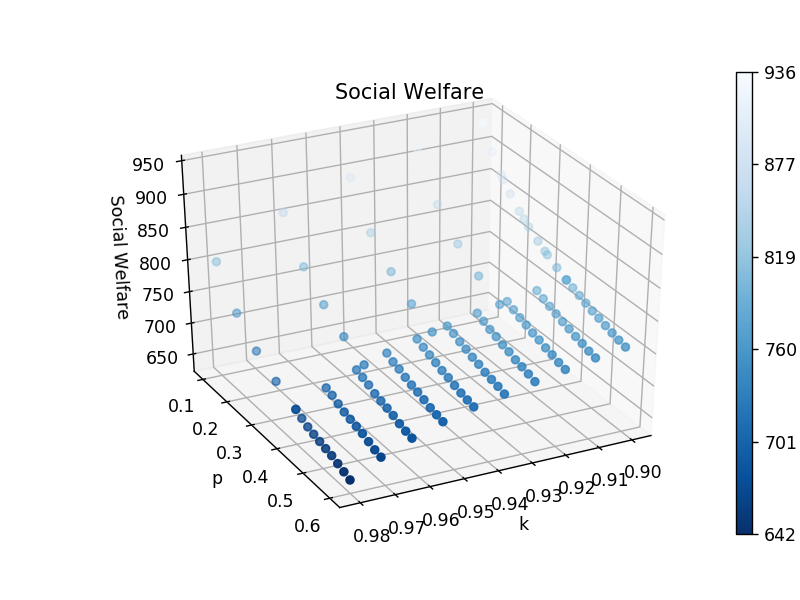

In [2]:
import numpy as np  # 用来处理数据
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.colors 
import matplotlib.ticker
import matplotlib as mpl

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

%matplotlib notebook

fig = plt.figure()
min_v = min(plotSocialWelfare)
max_v = max(plotSocialWelfare)
color = [plt.get_cmap("Blues_r", 100)(int(float(i-min_v)/(max_v-min_v)*100)) for i in plotSocialWelfare]

 
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
plt.set_cmap(plt.get_cmap("Blues_r", 100))
ax.set_title('Social Welfare')  # 设置本图名称
im=ax.scatter(kk,pp,plotSocialWelfare,c =color)   # 绘制数据点 c: 'r'红色，'y'黄色，等颜色
ax.view_init(elev=33, azim=63)
# fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)))

ax.set_xlabel('k')  # 设置x坐标轴
ax.set_ylabel('p')  # 设置y坐标轴
ax.set_zlabel('Social Welfare')  # 设置z坐标轴

cax = add_right_cax(ax, pad=0.02, width=0.02)
cbar = fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)),cax=cax)
# plt.savefig('SocialWelfare.pdf')
plt.show()

#### Firm

<IPython.core.display.Javascript object>


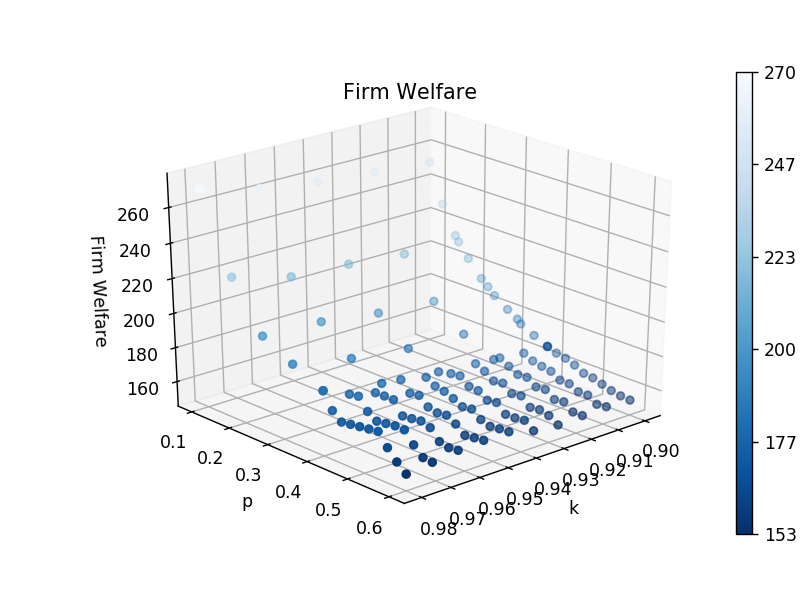

In [12]:
import numpy as np  # 用来处理数据
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.colors 
import matplotlib.ticker
import matplotlib as mpl

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

%matplotlib notebook

fig = plt.figure()
min_v = min(plotFirmWelfare)
max_v = max(plotFirmWelfare)
color = [plt.get_cmap("Blues_r", 100)(int(float(i-min_v)/(max_v-min_v)*100)) for i in plotFirmWelfare]

 
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
plt.set_cmap(plt.get_cmap("Blues_r", 100))
ax.set_title('Firm Welfare')  # 设置本图名称
im=ax.scatter(kk,pp,plotFirmWelfare,c =color)   # 绘制数据点 c: 'r'红色，'y'黄色，等颜色
ax.view_init(elev=33, azim=63)
# fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)))

ax.set_xlabel('k')  # 设置x坐标轴
ax.set_ylabel('p')  # 设置y坐标轴
ax.set_zlabel('Firm Welfare')  # 设置z坐标轴

cax = add_right_cax(ax, pad=0.02, width=0.02)
cbar = fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)),cax=cax)
# plt.savefig('SocialWelfare.pdf')
plt.show()

# 把BBB加在效用函数里面 

In [7]:
import numpy as np

kmin=0.6
kmax=0.98
pmin=0.1
pmax=0.9
kk=np.linspace(kmin,kmax,8)#行向量
pp=np.linspace(pmin,pmax,8)
kk=kk.reshape((1,8))
pp=pp.reshape((1,8))
#print(k)
ones=np.ones((8,1))
#print(ones)
kk=np.dot(ones,kk)
pp=np.dot(ones,pp)
# print(k)
kk=np.transpose(kk)
kk=kk.reshape((64,1))
pp=pp.reshape((64,1))
# print(k)
Parameter=np.hstack((kk,pp))
Welfare=np.zeros((64,1))
FirmWelfare=np.zeros((64,1))
SocialWelfare=np.zeros((64,1))

把$\epsilon$的绝对值调小一些，可以扩大k的可使用范围

In [6]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.sparse import spdiags
from datetime import datetime
from openpyxl import load_workbook
from scipy.sparse import identity
import copy

for i in range(0,64,1):
    BBBB=200;
    k=Parameter[i,0];
    p=Parameter[i,1];
    for count in range(0,50,1):
        gamma=0.9;
        epsilon=-0.2;

        rho=0.9;
        C=50;

        a=0.8;
        eta=0.6;
        xmean=a/eta;
        sigma=0.8;
        sd=sigma**2/2/eta
        xmin=xmean-2*sd
        xmax=xmean+2*sd

        I=1000;
        hmin=0.0001;
        hmax=100;
        h=np.linspace(hmin,hmax,I);   #列向量  
                                      #linspace(start,stop,num)生成array对象,num是点的数量，包括两端
        h=h.reshape(I,1);
        #print(h);
        dh=(hmax-hmin)/(I-1);

        J=7;
        x=np.linspace(xmin,xmax,J);    # 行向量
        x=x.reshape(1,J);    #此时x的输出结果为[[2  6  5  4]]，可以用x[0][1]来调取
        dx=(xmax-xmin)/(J-1);
        dx2=dx**2;

        hh=np.dot(h,np.ones((1,J)));
        xx=np.dot(np.ones((I,1)),x);

        mu=a-x*eta;      
        s2=0.5*sigma**2;

        Vhf = np.zeros((I,J));
        Vhb = np.zeros((I,J));
        Vxf = np.zeros((I,J));
        Vxb = np.zeros((I,J));
        Vxx = np.zeros((I,J));
        n = np.zeros((I,J));

        chi =  - np.minimum(mu,0)/dx + s2/dx2;              
        yy =  np.minimum(mu,0)/dx - np.maximum(mu,0)/dx - s2*2/dx2;
        zeta = np.maximum(mu,0)/dx + s2/dx2;

        maxit=100;
        crit=10**(-6);
        Delta=1000;

        updiag=np.zeros((I,1));
        for j in range(0,J,1):
            gg=np.tile(zeta[0][j],(I,1));
            updiag=np.vstack([updiag,gg]);

        centdiag=np.tile(chi[0][0]+yy[0][0],(I,1))
        for j in range(1,J-1,1):
            gg=np.tile(yy[0][j],(I,1));
            centdiag=np.vstack([centdiag,gg]);
        gg=np.tile(yy[0][J-1]+zeta[0][J-1],(I,1))
        centdiag=np.vstack([centdiag,gg])

        lowdiag=np.tile(chi[0][1],(I,1));
        for j in range(2,J,1):
            gg=np.tile(chi[0][j],(I,1));
            lowdiag=np.vstack([lowdiag,gg]);

        centdiag=np.transpose(centdiag);
        Bswitch_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();
        lowdiag=np.transpose(lowdiag);
        Bswitch_lowdiag=spdiags(lowdiag,-I,I*J,I*J).toarray();
        updiag=np.transpose(updiag);
        Bswitch_updiag=spdiags(updiag,I,I*J,I*J).toarray();
        Bswitch=Bswitch_centdiag+Bswitch_lowdiag+Bswitch_updiag;

        v0=(xx*hh**(1-gamma)/(1-gamma))/rho;
        v=v0;

        maxit=30;
        distm=np.zeros(maxit);
        for m in range(0,maxit,1):   
            V=copy.deepcopy(v);
            Vhf=np.zeros((I,J));
            Vhf[0:I-1,:]=(V[1:I,:]-V[0:I-1,:])/dh;
            Vhf[I-1,:]=(V[I-1,:]-V[I-2,:])/dh;

            Vhb=np.zeros((I,J));
            Vhb[1:I,:]=(V[1:I,:]-V[0:I-1,:])/dh;
            Vhb[0,:]=(V[1,:]-V[0,:])/dh;

            I_concave=(Vhb>Vhf)+0;

            nf=((1-k)/C*Vhf)**epsilon;
            hf=(1-k)*nf-p*hh;

            nb=((1-k)/C*Vhb)**epsilon;
            hb=(1-k)*nb-p*hh;

            n0=p/(1-k)*hh;
            Vh0=C/(1-k)*n0**(1/epsilon);

            If=(hf>0)+0;
            Ib=(hb<0)+0;

            I0=(1-If-Ib);

            Vh_Upwind=Vhf*If+Vhb*Ib+Vh0*I0;

            n=((1-k)/C*Vh_Upwind)**epsilon;
            u=BBBB+xx*hh**(1-gamma)/(1-gamma)-C/(1+1/epsilon)*n**(1+1/epsilon);

            aaa=np.nan_to_num(hf,nan=0)
            hf=aaa
            aaa=np.nan_to_num(hb,nan=0)
            hb=aaa

            X=-np.minimum(hb,0)/dh;
            Y=-np.maximum(hf,0)/dh+np.minimum(hb,0)/dh;
            Z=np.maximum(hf,0)/dh;

            updiag=0;
            for j in range(0,J,1):
                pp=Z[0:I-1,j];
                pp=pp.reshape(I-1,1)
                gg=np.vstack([pp,0]);
                updiag=np.vstack([updiag,gg]);

            Y=np.transpose(Y);
            centdiag=Y.reshape(I*J,1);   #按行来reshape    python中的reshape是按行的，但此处我需要按列来，所以转置

            lowdiag=X[1:I,0];
            lowdiag=lowdiag.reshape(I-1,1);
            for j in range(1,J,1):
                pp=X[1:I,j];
                pp=pp.reshape(I-1,1);
                gg=np.vstack([0,pp]);
                lowdiag=np.vstack([lowdiag,gg]);

            centdiag=np.transpose(centdiag);
            AA_centdiag=spdiags(centdiag,0,I*J,I*J).toarray();

            lowdiag=np.vstack([lowdiag,0]);
            lowdiag=np.transpose(lowdiag);
            AA_lowdiag=spdiags(lowdiag,-1,I*J,I*J).toarray();

            updiag=np.vstack([updiag,0]);
            updiag=np.transpose(updiag);
            AA_updiag=spdiags(updiag,1,I*J,I*J).toarray();

            AA=AA_centdiag+AA_lowdiag+AA_updiag;

            A=AA+Bswitch;

            if np.max(abs(np.sum(A,axis=1)))>10**(-9):   #这个最大值不太一样    
                print("Improper Transition Matrix")
                break;

            B=(1/Delta+rho)*identity(I*J).toarray()-A;
            invB=np.linalg.inv(B);

            u=np.transpose(u);
            u_stacked=copy.deepcopy(u.reshape(I*J,1));
            V=np.transpose(V);
            V_stacked=copy.deepcopy(V.reshape(I*J,1));


            b=u_stacked+V_stacked/Delta;

            invBcopy=copy.deepcopy(invB);

            bcopy=np.tile(np.transpose(b),(I*J,1))
            index=np.where(np.isnan(bcopy))
        #     for i in range(0,len(index[0]),1):
        #         if invBcopy[index[0][i],index[1][i]]==0:
        #             bcopy[index[0][i],index[1][i]]=0

        #     index=np.where(np.isinf(bcopy))
        #     for i in range(0,len(index[0]),1):
        #         if invBcopy[index[0][i],index[1][i]]==0:
        #             bcopy[index[0][i],index[1][i]]=0

            V_stacked2=invBcopy*bcopy
            V_stacked2=V_stacked2.sum(axis=1)
            V_stacked2=V_stacked2.reshape(I*J,1)


            V=copy.deepcopy(V_stacked2.reshape(J,I));
            V=np.transpose(V);  #matlab是按列来进行reshape，python按行来reshape

            Vchange=V-v;

            v=copy.deepcopy(V);

            Vchangecopy=copy.deepcopy(Vchange)
            aaa=np.nan_to_num(Vchangecopy,nan=0,posinf=0,neginf=0)  
            Vchangecopy=aaa

            distm[m]=np.max(np.max(abs(Vchangecopy),axis=0));
            print(distm[m]);
            print(m);
            if distm[m]<crit:
                print("Value Function Converged, Iteration =",m,distm[m]);
                break;

        AT=np.transpose(A)
        b5=np.zeros((I*J,1))
        i_fix=5
        b5[i_fix-1,0]=0.1
        row=np.hstack([np.zeros(i_fix-1),1,np.zeros(I*J-i_fix)])
        AT[i_fix-1,:]=row
        invAT=np.linalg.inv(AT);
        gg=np.dot(invAT,b5);

        g_sum=np.dot(np.transpose(gg),np.ones((I*J,1)))*dh*dx

        gg=gg/g_sum
        # g=np.transpose(gg).reshape(I,J)
        ggcopy=copy.deepcopy(gg)
        # ggcopy=np.transpose(ggcopy)
        g=ggcopy.reshape(J,I)
        g=np.transpose(g)

        T=k*n+p*hh

        Tg=T*g
        TFW1=np.dot(np.ones((1,I)),Tg)
        TotalFirmWelfare=np.dot(TFW1,np.ones((J,1)))
    #     print('k=',k,'p=',p,'FirmWelfare=',TotalFirmWelfare)
    #     FirmWelfare[i,0]=TotalFirmWelfare

        Vg=V*g
        TSW1=np.dot(np.ones((1,I)),Vg)
        TotalSocialWelfare=np.dot(TSW1,np.ones((J,1)))

        # D=TotalSocialWelfare-TotalFirmWelfare

        # print('次数=',i,'k=',k,'p=',p,'TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'作差=',D)
        print('TSW=',TotalSocialWelfare,'TFW=',TotalFirmWelfare,'BBBB',BBBB)
        if abs(BBBB-TotalFirmWelfare)<=0.5:
            print('求B的次数',count+1,'第几组k和p',i+1,'最后迭代出的B值',BBBB)
            break
        elif BBBB>TotalFirmWelfare:
            BBBB=TotalFirmWelfare+0.3
        elif BBBB<TotalFirmWelfare:
            BBBB=TotalFirmWelfare-0.3

#         Welfare[i,0]=D
        SocialWelfare[i,0]=TotalSocialWelfare
        FirmWelfare[i,0]=TotalFirmWelfare

232.2053984044622
0
0.850972278724214
1
0.10337373320834331
2
0.0006758322374196268
3
1.3343191085368744e-07
4
Value Function Converged, Iteration = 4 1.3343191085368744e-07
TSW= [[6796.06399921]] TFW= [[116.14901133]] BBBB 200
139.47400143222774
0
0.953892808105195
1
0.10348796243067682
2
0.0006759590179967745
3
1.3357259831536794e-07
4
Value Function Converged, Iteration = 4 1.3357259831536794e-07
TSW= [[4187.70396324]] TFW= [[116.14901133]] BBBB [[116.44901133]]
求B的次数 2 第几组k和p 1 最后迭代出的B值 [[116.44901133]]
231.97345415014567
0
0.8627323939621476
1
0.10686331095800483
2
0.000751149472648649
3
1.6084541698546673e-07
4
Value Function Converged, Iteration = 4 1.6084541698546673e-07
TSW= [[6749.44996701]] TFW= [[100.96483361]] BBBB 200
122.38947369538485
0
0.9843572335345527
1
0.10699829968115182
2
0.0007512992935687635
3
1.6101162714221573e-07
4
Value Function Converged, Iteration = 4 1.6101162714221573e-07
TSW= [[3667.05840888]] TFW= [[100.96483361]] BBBB [[101.26483361]]
求B的次数 2 第几组k和p 

8.777920919555982e-05
3
1.582014874657034e-08
4
Value Function Converged, Iteration = 4 1.582014874657034e-08
TSW= [[6779.26043582]] TFW= [[117.0501995]] BBBB 200
140.45940613942693
0
0.7930768588309718
1
0.04240141195924707
2
8.790462234742336e-05
3
1.5959273014232167e-08
4
Value Function Converged, Iteration = 4 1.5959273014232167e-08
TSW= [[4199.03439626]] TFW= [[117.0501995]] BBBB [[117.3501995]]
求B的次数 2 第几组k和p 17 最后迭代出的B值 [[117.3501995]]
231.95726678489578
0
0.7037195785450763
1
0.043549136377009745
2
9.367278875060947e-05
3
1.6957898196778842e-08
4
Value Function Converged, Iteration = 4 1.6957898196778842e-08
TSW= [[6734.05697023]] TFW= [[101.73396804]] BBBB 200
123.22693164753144
0
0.8243969760338246
1
0.043683073555286
2
9.382144253322622e-05
3
1.7122886220022338e-08
4
Value Function Converged, Iteration = 4 1.7122886220022338e-08
TSW= [[3675.67685164]] TFW= [[101.73396804]] BBBB [[102.03396804]]
求B的次数 2 第几组k和p 18 最后迭代出的B值 [[102.03396804]]
231.73151953632672
0
0.71624321070694

1.5907346551102819e-09
4
Value Function Converged, Iteration = 4 1.5907346551102819e-09
TSW= [[6755.45104448]] TFW= [[118.38519121]] BBBB 200
141.92492269152262
0
0.5318983075645463
1
0.012351958289031018
2
7.559670109458239e-06
3
1.7277557162742596e-09
4
Value Function Converged, Iteration = 4 1.7277557162742596e-09
TSW= [[4216.90181889]] TFW= [[118.38519121]] BBBB [[118.68519121]]
求B的次数 2 第几组k和p 33 最后迭代出的B值 [[118.68519121]]
231.9395492611837
0
0.4427306227031522
1
0.01263290852176624
2
7.881327690029138e-06
3
1.710617425487726e-09
4
Value Function Converged, Iteration = 4 1.710617425487726e-09
TSW= [[6712.25256664]] TFW= [[102.89417329]] BBBB 200
124.49690030261675
0
0.5619788457427148
1
0.012765259490720382
2
8.028221117228895e-06
3
1.873701194199384e-09
4
Value Function Converged, Iteration = 4 1.873701194199384e-09
TSW= [[3690.09264182]] TFW= [[102.89417329]] BBBB [[103.19417329]]
求B的次数 2 第几组k和p 34 最后迭代出的B值 [[103.19417329]]
231.71193542857475
0
0.4537288876219634
1
0.0130149820615

3.0424342867263476e-07
3
Value Function Converged, Iteration = 3 3.0424342867263476e-07
TSW= [[6712.376412]] TFW= [[120.97388559]] BBBB 200
144.77945603406988
0
0.15367362057870082
1
0.0008629599249729836
2
2.5384969148944947e-07
3
Value Function Converged, Iteration = 3 2.5384969148944947e-07
TSW= [[4254.64307008]] TFW= [[120.97388559]] BBBB [[121.27388559]]
求B的次数 2 第几组k和p 49 最后迭代出的B值 [[121.27388559]]
231.91909174125007
0
0.25033876634250873
1
0.000800676842914072
2
3.038181262127182e-07
3
Value Function Converged, Iteration = 3 3.038181262127182e-07
TSW= [[6672.79372547]] TFW= [[105.14058763]] BBBB 200
126.96968844451504
0
0.16682014761602204
1
0.0009299565596734283
2
3.0149425356285064e-07
3
Value Function Converged, Iteration = 3 3.0149425356285064e-07
TSW= [[3720.76411851]] TFW= [[105.14058763]] BBBB [[105.44058763]]
求B的次数 2 第几组k和p 50 最后迭代出的B值 [[105.44058763]]
231.68921360144762
0
0.25004025208986036
1
0.0008450234414283386
2
3.034043629668304e-07
3
Value Function Converged, Itera

## 画图

### 设置参数

In [7]:
print(FirmWelfare)
print("--------------------------------")
print(SocialWelfare)
print("--------------------------------")

[[116.14901133]
 [100.96483361]
 [ 94.20998095]
 [ 90.20624634]
 [ 87.62888397]
 [ 85.64681371]
 [ 84.27485187]
 [ 83.15841528]
 [116.56393505]
 [101.31469352]
 [ 94.53656173]
 [ 90.52850481]
 [ 87.93034312]
 [ 86.00339749]
 [ 84.60143822]
 [ 83.43940207]
 [117.0501995 ]
 [101.73396804]
 [ 94.90805449]
 [ 90.95704975]
 [ 88.2660052 ]
 [ 86.37092954]
 [ 84.97440681]
 [ 83.81303619]
 [117.63922376]
 [102.2367733 ]
 [ 95.43267975]
 [ 91.39845998]
 [ 88.6767886 ]
 [ 86.76165853]
 [ 85.37264253]
 [ 84.27558466]
 [118.38519121]
 [102.89417329]
 [ 95.99461231]
 [ 91.9191345 ]
 [ 89.1961176 ]
 [ 87.32425461]
 [ 85.82078475]
 [ 84.68672288]
 [119.41516491]
 [103.75579758]
 [ 96.78049502]
 [ 92.70679966]
 [ 90.04045005]
 [ 87.88095373]
 [ 86.38887617]
 [ 85.6135024 ]
 [120.97388559]
 [105.14058763]
 [ 98.11531878]
 [ 94.0994451 ]
 [ 91.39529637]
 [ 89.28333933]
 [ 86.88185331]
 [ 86.255554  ]
 [124.90076521]
 [108.10343047]
 [102.1252576 ]
 [ 94.98339395]
 [ 75.20211187]
 [ 67.54128606]
 [ 68.14

In [8]:
kk=Parameter[:,0]
pp=Parameter[:,1]
kk=kk.flatten()
pp=pp.flatten()

In [9]:
plotFirmWelfare=[[116.14901133],
 [100.96483361],
 [ 94.20998095],
 [ 90.20624634],
 [ 87.62888397],
 [ 85.64681371],
 [ 84.27485187],
 [ 83.15841528],
 [116.56393505],
 [101.31469352],
 [ 94.53656173],
 [ 90.52850481],
 [ 87.93034312],
 [ 86.00339749],
 [ 84.60143822],
 [ 83.43940207],
 [117.0501995 ],
 [101.73396804],
 [ 94.90805449],
 [ 90.95704975],
 [ 88.2660052 ],
 [ 86.37092954],
 [ 84.97440681],
 [ 83.81303619],
 [117.63922376],
 [102.2367733 ],
 [ 95.43267975],
 [ 91.39845998],
 [ 88.6767886 ],
 [ 86.76165853],
 [ 85.37264253],
 [ 84.27558466],
 [118.38519121],
 [102.89417329],
 [ 95.99461231],
 [ 91.9191345 ],
 [ 89.1961176 ],
 [ 87.32425461],
 [ 85.82078475],
 [ 84.68672288],
 [119.41516491],
 [103.75579758],
 [ 96.78049502],
 [ 92.70679966],
 [ 90.04045005],
 [ 87.88095373],
 [ 86.38887617],
 [ 85.6135024 ],
 [120.97388559],
 [105.14058763],
 [ 98.11531878],
 [ 94.0994451 ],
 [ 91.39529637],
 [ 89.28333933],
 [ 86.88185331],
 [ 86.255554  ],
 [124.90076521],
 [108.10343047],
 [102.1252576 ],
 [ 94.98339395],
 [ 75.20211187],
 [ 67.54128606],
 [ 68.14948503],
 [ 69.08705702]]
plotFirmWelfare=np.array(plotFirmWelfare)
plotFirmWelfare=plotFirmWelfare.flatten()
plotSocialWelfare=[[6796.06399921],
 [6749.44996701],
 [6725.73286203],
 [6710.15580326],
 [6698.73715279],
 [6689.73546754],
 [6682.40246456],
 [6676.19945546],
 [6788.26045339],
 [6742.2997585 ],
 [6718.91732339],
 [6703.5633509 ],
 [6692.29966082],
 [6683.44123063],
 [6676.20366591],
 [6670.07400589],
 [6779.26043582],
 [6734.05697023],
 [6711.05258557],
 [6695.97578937],
 [6684.87240155],
 [6676.16995795],
 [6669.05159995],
 [6663.02107483],
 [6768.59724267],
 [6724.28838612],
 [6701.75974081],
 [6686.9602705 ],
 [6676.06877372],
 [6667.53496122],
 [6660.55634008],
 [6654.66217257],
 [6755.45104448],
 [6712.25256664],
 [6690.26715469],
 [6675.8280384 ],
 [6665.20893386],
 [6656.89871381],
 [6650.05935805],
 [6644.29445248],
 [6738.16630616],
 [6696.41008506],
 [6675.15385184],
 [6661.2070092 ],
 [6650.95769627],
 [6642.83130175],
 [6636.21576663],
 [6630.74382117],
 [6712.376412  ],
 [6672.79372547],
 [6652.6336168 ],
 [6639.41268492],
 [6629.67134605],
 [6621.90563474],
 [6615.33889022],
 [6610.03733681],
 [6656.0015533 ],
 [6620.82442287],
 [6603.25746092],
 [6589.71540559],
 [6565.77543776],
 [6538.15580998],
 [6521.56533274],
 [6509.29030345]]
plotSocialWelfare=np.array(plotSocialWelfare)
# print(np.transpose(plotSocialWelfare))
plotSocialWelfare=plotSocialWelfare.flatten()

### 画出图像

#### Social

<IPython.core.display.Javascript object>


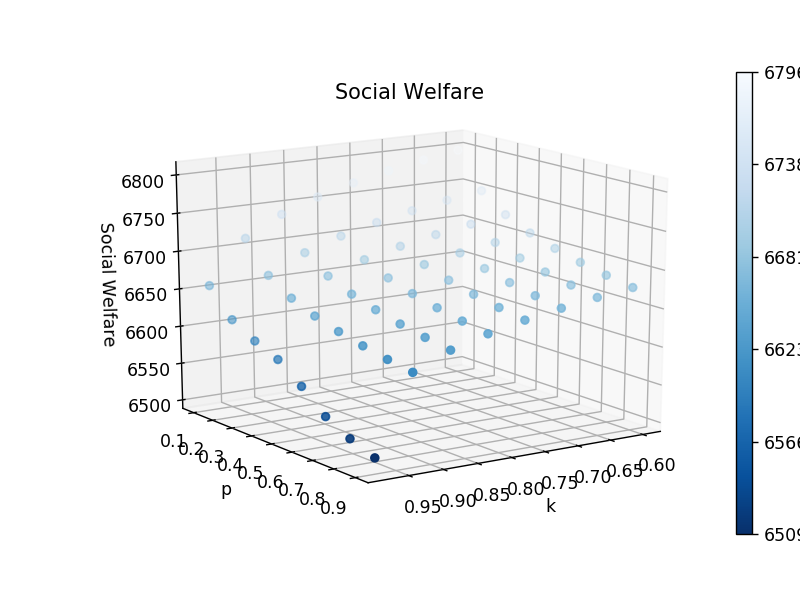

In [10]:
import numpy as np  # 用来处理数据
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.colors 
import matplotlib.ticker
import matplotlib as mpl

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

%matplotlib notebook

fig = plt.figure()
min_v = min(plotSocialWelfare)
max_v = max(plotSocialWelfare)
color = [plt.get_cmap("Blues_r", 100)(int(float(i-min_v)/(max_v-min_v)*100)) for i in plotSocialWelfare]

 
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
plt.set_cmap(plt.get_cmap("Blues_r", 100))
ax.set_title('Social Welfare')  # 设置本图名称
im=ax.scatter(kk,pp,plotSocialWelfare,c =color)   # 绘制数据点 c: 'r'红色，'y'黄色，等颜色
ax.view_init(elev=33, azim=63)
# fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)))

ax.set_xlabel('k')  # 设置x坐标轴
ax.set_ylabel('p')  # 设置y坐标轴
ax.set_zlabel('Social Welfare')  # 设置z坐标轴

cax = add_right_cax(ax, pad=0.02, width=0.02)
cbar = fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)),cax=cax)
# plt.savefig('SocialWelfare.pdf')
plt.show()

#### Firm

<IPython.core.display.Javascript object>


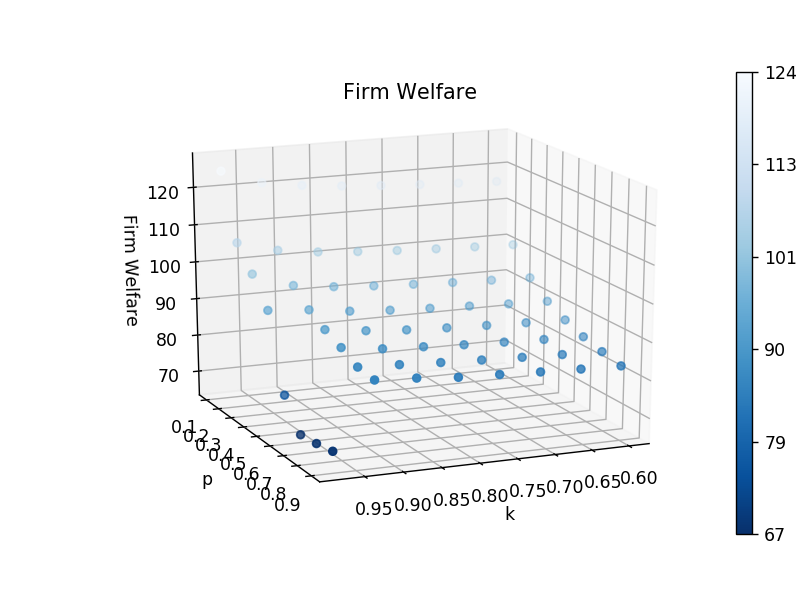

In [11]:
import numpy as np  # 用来处理数据
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.colors 
import matplotlib.ticker
import matplotlib as mpl

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

%matplotlib notebook

fig = plt.figure()
min_v = min(plotFirmWelfare)
max_v = max(plotFirmWelfare)
color = [plt.get_cmap("Blues_r", 100)(int(float(i-min_v)/(max_v-min_v)*100)) for i in plotFirmWelfare]

 
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
plt.set_cmap(plt.get_cmap("Blues_r", 100))
ax.set_title('Firm Welfare')  # 设置本图名称
im=ax.scatter(kk,pp,plotFirmWelfare,c =color)   # 绘制数据点 c: 'r'红色，'y'黄色，等颜色
ax.view_init(elev=33, azim=63)
# fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)))

ax.set_xlabel('k')  # 设置x坐标轴
ax.set_ylabel('p')  # 设置y坐标轴
ax.set_zlabel('Firm Welfare')  # 设置z坐标轴

cax = add_right_cax(ax, pad=0.02, width=0.02)
cbar = fig.colorbar(im, format=matplotlib.ticker.FuncFormatter(lambda x,pos:int(x*(max_v-min_v)+min_v)),cax=cax)
# plt.savefig('SocialWelfare.pdf')
plt.show()

# 把BBB乘在dx里